# Parcial Punto 2 - RETORNO

Este Jupyter Book resume los modelos estadisticos solicitados para las diferentes ventanas de tiempo de predición para la serie de tiempo Bitcoin Retorno. Los modelos de Garch serán revisados con la serie de tiempo de volatilidad, pues este es uso.

## LIBRERIAS Y FUNCIONES

### Librerias

In [12]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import plotly.express as px
from statsmodels.tsa import stattools
from statsmodels.stats.stattools import jarque_bera
import scipy.stats as stats
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import itertools
from tqdm import tqdm  # Para mostrar una barra de progreso
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import Holt
from statsmodels.graphics.tsaplots import plot_predict, plot_acf

#Formato y colores
from IPython.display import display, HTML

### Accuracy

In [13]:
def forecast_accuracy(forecast, actual, str_name, str_model, lj_lags = [10], window_str = ''):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))    # MAPE
    mae = np.mean(np.abs(forecast - actual))                      # MAE
    mse = np.mean((forecast - actual) ** 2)                       # MSE
    rmse = np.sqrt(mse)                                           # RMSE

    # Cálculo del R²
    ss_res = np.sum((actual - forecast) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # Cálculo de los residuales
    residuals = actual - forecast

    # Prueba de Ljung-Box
    lb_test = acorr_ljungbox(residuals, lags=lj_lags, return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[-1]  # p-valor en el lag máximo especificado (10 en este caso)

    # Prueba de Jarque-Bera
    jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(residuals)

    df_acc = pd.DataFrame({
        'model': str_model,
        'window': window_str,
        'MAE': [mae],
        'MSE': [mse],
        'MAPE': [mape],
        'RMSE': [rmse],
        'R2': [r2],
        'Ljung-Box p-value': [lb_pvalue],
        'Jarque-Bera p-value': [jb_pvalue]
    }, index=[str_name])

    return df_acc





### Residuos - Independencia y normalidad

In [14]:
def independence_normality(residuals, nlags_ljbox):
    print('----- Test de Independencia  Ljung-Box --------')
  
    # Ho: no hay autocorrelación en los residuos
    acf_, confint_, qstat_, pvalues_ = stattools.acf(residuals, nlags=nlags_ljbox, qstat=True, alpha=0.05)
    alpha = 0.05
  
    for l, p_val in enumerate(pvalues_):
        if p_val > alpha:
            print('Null hypothesis is accepted at lag = {} for p-val = {}'.format(l, p_val))
        else:
            print('Null hypothesis is rejected at lag = {} for p-val = {}'.format(l, p_val))
  
    print('----- Test de Normalidad  Jarque-Bera --------')

    # Jarque-Bera
    # Ho: los residuos tienen distribución normal
    JB, JBpv, skew, kurtosis = jarque_bera(residuals)

    if JBpv > alpha:
        print('Null hypothesis is accepted, residuos normales')
    else:
        print('Null hypothesis is rejected, residuos no normales')

    # Gráfico de la serie temporal de los residuos
    print('----- Grafico de serie de residuos --------')
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuos')
    plt.title('Serie Temporal de los Residuos')
    plt.xlabel('Fecha')
    plt.ylabel('Residuos')
    plt.legend()
    plt.show()

    # Q-Q Plot
    print('----- QQ Plot --------')
    qq = stats.probplot(residuals, dist="norm")
    teoricos = qq[0][0]  # Cuantiles teóricos
    observados = qq[0][1]  # Cuantiles observados (residuos)

    plt.figure(figsize=(10, 6))
    plt.scatter(teoricos, observados, label='Observados')
    plt.plot(teoricos, teoricos, color='firebrick', linestyle='--', label='Línea de referencia')
    plt.title('Q-Q Plot de los Residuos')
    plt.xlabel('Teóricos')
    plt.ylabel('Observados')
    plt.legend()
    plt.show()

    print('----- ACF de Residuos --------')
    fig = plt.figure(figsize=(5.5, 5.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('ACF of Residuals')
    autocorrelation_plot(residuals, color='b', ax=ax)
    plt.show()  # Asegura que se renderice al instante




### Grafica Train, Val. y Test

In [15]:
def plot_model(train, val, test, y_pred, title):
    import pandas as pd
    import plotly.express as px
    from sklearn.metrics import mean_absolute_error

    # Prepare the data
    train_df = pd.DataFrame({
        'Time': train[-300:].index,
        'Value': train[-300:].values,
        'Category': 'Train'
    })
    val_df = pd.DataFrame({
        'Time': val.index,
        'Value': val.values,
        'Category': 'Validation'
    })
    test_df = pd.DataFrame({
        'Time': test.index,
        'Value': test.values,
        'Category': 'Test'
    })
    y_pred_df = pd.DataFrame({
        'Time': y_pred.index,
        'Value': y_pred.values,
        'Category': 'Prediction'
    })

    # Combine the data
    df = pd.concat([train_df, val_df, test_df, y_pred_df], axis=0)

    # Add line dash style
    df['Dash'] = df['Category'].map({
        'Train': 'solid',
        'Validation': 'solid',
        'Test': 'solid',
        'Prediction': 'dash'
    })

    # Compute MAE
    mae = mean_absolute_error(test, y_pred)

    # Plot using Plotly Express
    fig = px.line(
        df,
        x='Time',
        y='Value',
        color='Category',
        line_dash='Dash',
        title=f"{title}, MAE: {round(mae, 2)}",
        color_discrete_map={
            'Train': 'blue',
            'Validation': 'orange',
            'Test': 'green',
            'Prediction': 'red'
        }
    )

    fig.update_layout(
        xaxis_title='Time',
        yaxis_title='Value',
        legend_title='',
        template='plotly_white'
    )

    fig.show()

### FX - Train, Val. y Test

In [16]:
def train_val_test(df, window):
  size = len(df)
  train_len = size - 56 # El profesor indicó que este siempre era el tamano del training (28+28)
  val_set_end = train_len + window
  test_set_end = val_set_end + window
  

  train_set = df[:train_len]
  val_set = df[train_len: val_set_end]
  test_set = df[val_set_end: test_set_end]

  return train_set, val_set, test_set

## DATOS

In [17]:
#Implemementacion de retorno
# retorno acumulado
def retorno_acumulado(df, columna):
    retorno_diario = (df[columna].diff() / df[columna].shift(1))
    return retorno_diario.cumsum()

In [18]:
# Data Original
data_init = pd.read_csv('https://raw.githubusercontent.com/lihkir/Data/refs/heads/main/Bitcoin%20Historical%20Data.csv', sep=',')
# Se crea una copia de la data para manipulación
df = data_init.copy(deep= True)

# Solo nos quedamos con las columnas Date y Price
df = df[['Date', 'Price']]

# Se elimina las comas de Price para poder convertirlo a números
df['Price'] = df['Price'].str.replace(',','')

#Convertimos las columnas price en números y date en fecha
df['Price'] = pd.to_numeric(df['Price'])
df['Date'] = pd.to_datetime(df['Date'])

#Creo la nueva columna
df["DailyReturn"] = retorno_acumulado(df, "Price")

# Se hace que el indice sea la columna Date
df.index = df['Date']
df.drop('Date', axis=1, inplace=True)

df = df.sort_index(ascending= True)
df_copy = df.copy(deep= True)
df.reset_index(drop=True, inplace=True)

timeserie = df["DailyReturn"]
timeserie = timeserie.dropna()

px.line(df, x= df.index,  y = df['DailyReturn'])

In [19]:
df.describe()

Price  DailyReturn
count   4999.000000  4998.000000
mean   10812.283337    -1.748842
std    15892.032468     1.308646
min        0.100000    -5.072978
25%      226.700000    -2.879595
50%     1975.100000    -1.339526
75%    15450.150000    -0.796875
max    73066.300000     0.723389

## MODELOS

In [20]:
#entanas para el set de validacion y test
windows = [7,14,21,28]
model_summary  = pd.DataFrame()

### SIMPLE EXPONENCIAL SMOOTHING (IMPLEMENTACIÓN SIN LIBRERIA) - RETORNO

In [21]:
# Función de Suavizado Exponencial Simple (SES) con verificación de datos
def firstsmooth(y, alpha, start=None):
    if len(y) == 0:
        raise ValueError("La serie de entrenamiento está vacía.")
        
    ytilde = y.copy()
    if start is None:
        start = y.iloc[0]
    ytilde.iloc[0] = alpha * y.iloc[0] + (1 - alpha) * start
    for i in range(1, len(y)):
        ytilde.iloc[i] = alpha * y.iloc[i] + (1 - alpha) * ytilde.iloc[i - 1]
    return ytilde

# Función para generar predicciones basadas en el último valor suavizado
def ses_forecast(train, val_length, alpha, start=None):
    # Aplicar SES al conjunto de entrenamiento
    ytilde = firstsmooth(train, alpha, start)
    if len(ytilde) == 0:
        raise ValueError("La serie suavizada está vacía.")
        
    last_smoothed = ytilde.iloc[-1]
    # Generar predicciones para el conjunto de validación
    y_pred = [last_smoothed] * val_length
    return y_pred

# Optimizador SES con verificación de datos
def ses_optimizer(train, val, alphas):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        y_pred = ses_forecast(train, len(val), alpha)
        mae = mean_absolute_error(val, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
    return best_alpha, best_mae

# Tuning del modelo
def ses_model_tuning(train, val):
    alphas = [round(a, 2) for a in list(np.arange(0.2, 1, 0.2))]
    best_alpha, best_mae = ses_optimizer(train, val, alphas)
    return best_alpha

#### Entrenamiento

In [22]:
best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_alpha = ses_model_tuning(train, val)
    best_params.append({'window': window, 'alpha': best_alpha})

In [23]:
best_params

[{'window': 7, 'alpha': 0.8},
 {'window': 14, 'alpha': 0.8},
 {'window': 21, 'alpha': 0.8},
 {'window': 28, 'alpha': 0.8}]

      model  window       MAE       MSE      MAPE      RMSE        R2  \
train   SSE       7  1.460938  3.466899  1.574052  1.861961 -1.036118   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         5.240430e-62  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


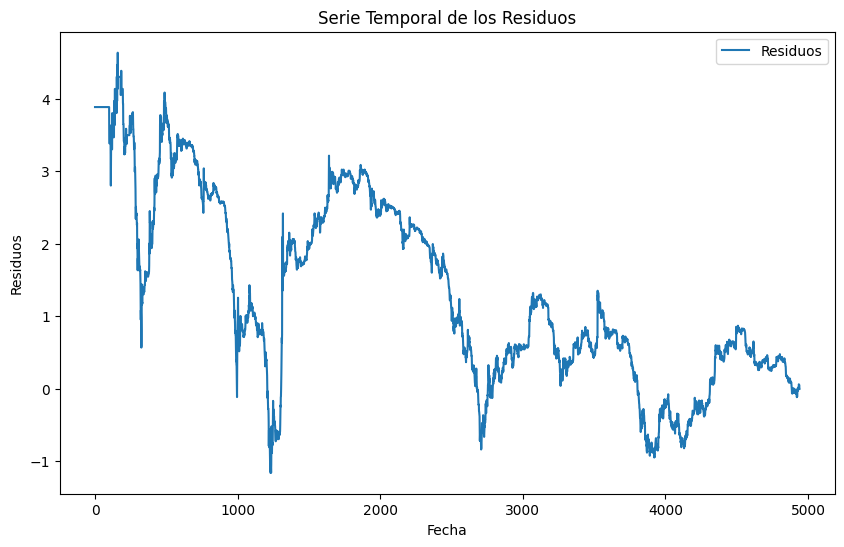

----- QQ Plot --------


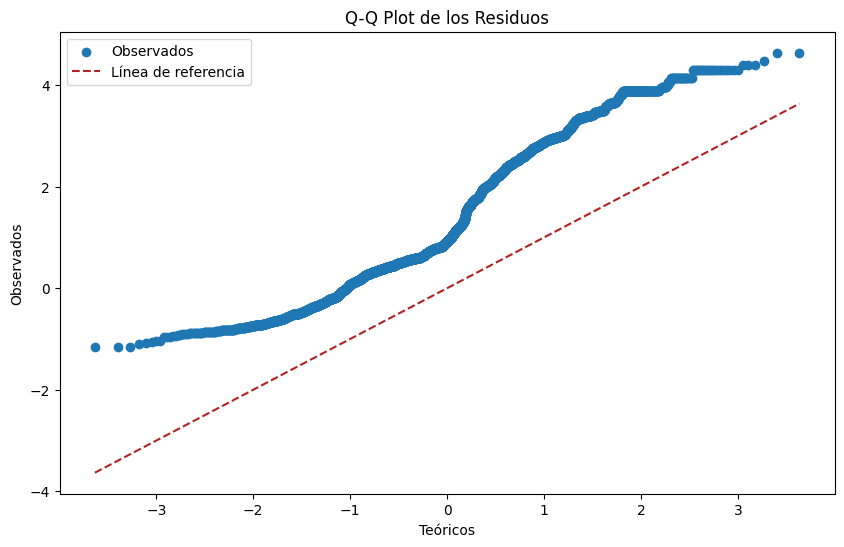

----- ACF de Residuos --------


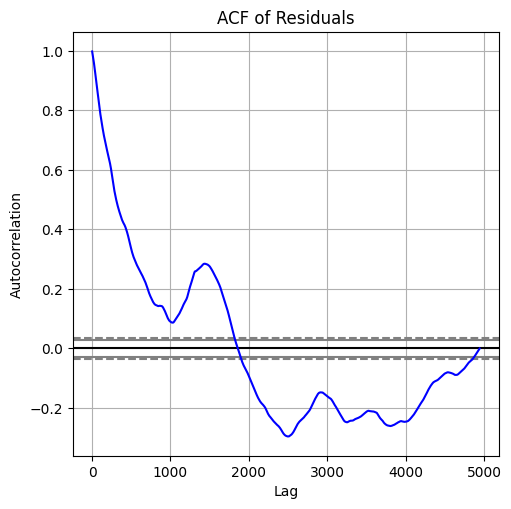

      model  window       MAE       MSE      MAPE      RMSE        R2  \
train   SSE      14  1.460938  3.466899  1.574052  1.861961 -1.036118   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         5.240430e-62  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


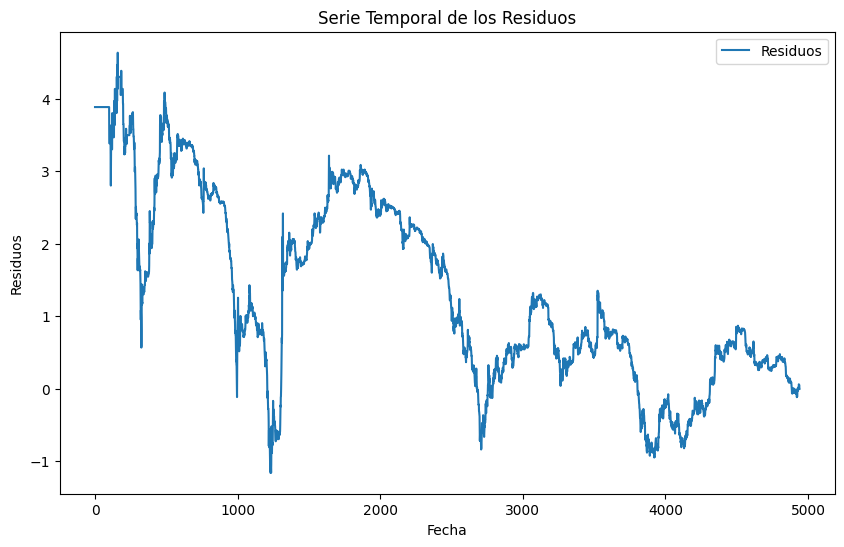

----- QQ Plot --------


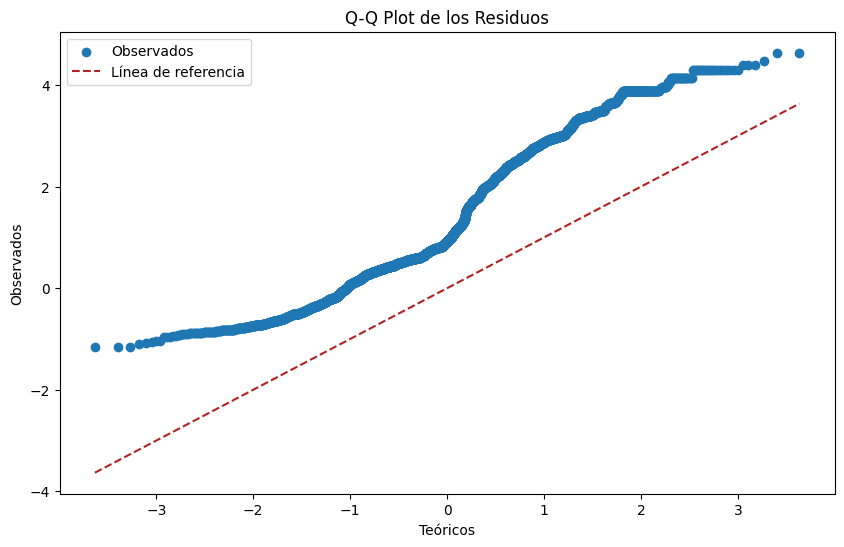

----- ACF de Residuos --------


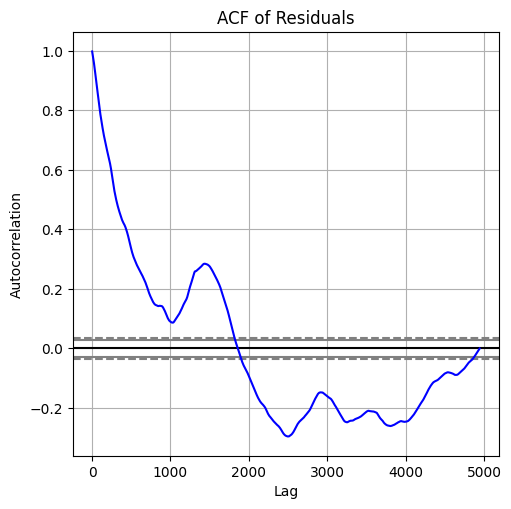

      model  window       MAE       MSE      MAPE      RMSE        R2  \
train   SSE      21  1.460938  3.466899  1.574052  1.861961 -1.036118   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         5.240430e-62  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


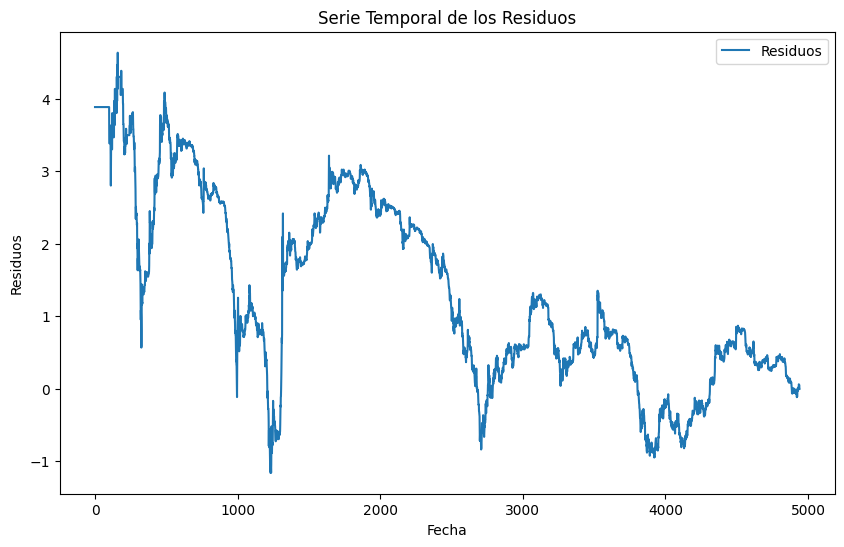

----- QQ Plot --------


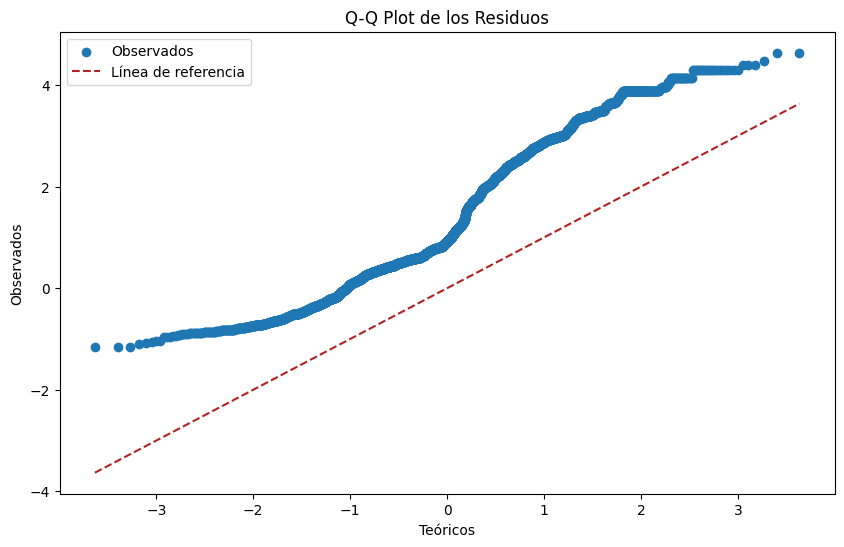

----- ACF de Residuos --------


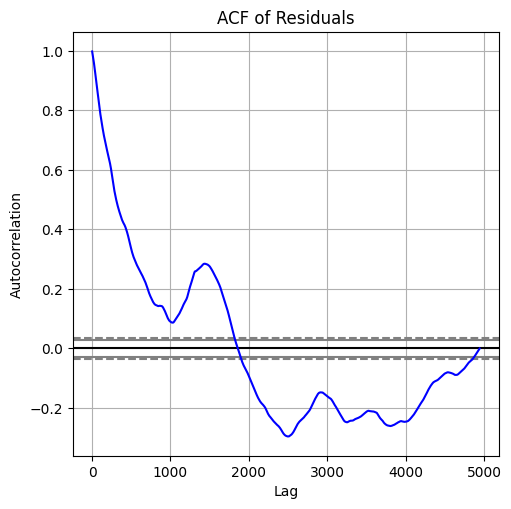

      model  window       MAE       MSE      MAPE      RMSE        R2  \
train   SSE      28  1.460938  3.466899  1.574052  1.861961 -1.036118   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         5.240430e-62  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


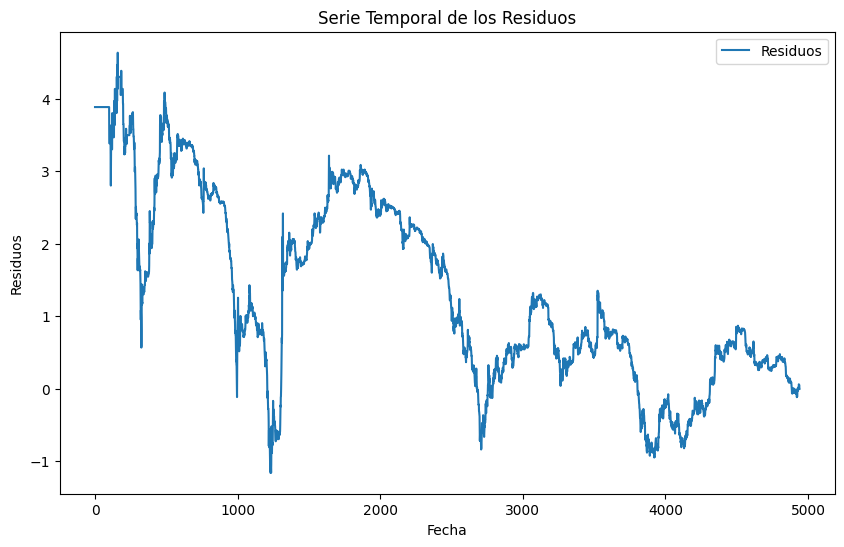

----- QQ Plot --------


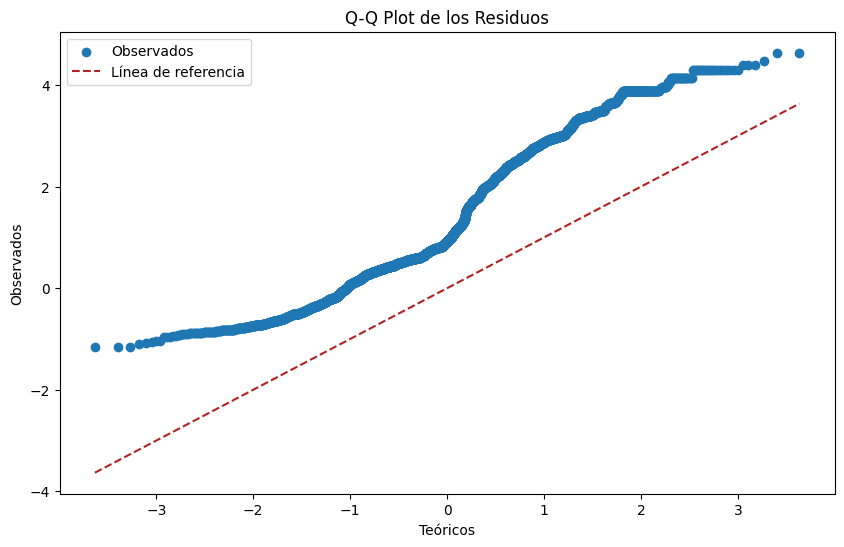

----- ACF de Residuos --------


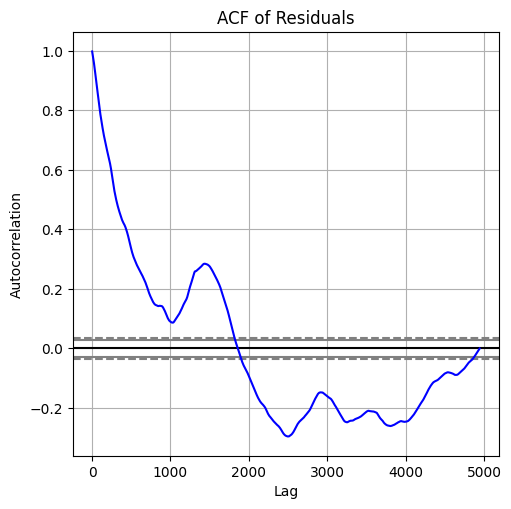

In [24]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    #pred = firstsmooth(train,param['alpha'])
    pred = ses_forecast(train,len(train),param['alpha'])
    residuals = pred - train
    metrics = forecast_accuracy(pred,train, 'train', 'SSE',[10],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)



Debido a que el parametro encontrado para cada ventana es igual, se realiza una sola interpretación para las metricas del set de entrenamiento:


- **Métricas de Error**:
   - Los errores (MAE, MSE) en el conjunto de entrenamiento para la suavización exponencial muestran un nivel aceptable, pero la magnitud específica dependerá del contexto de la serie de tiempo y su variabilidad.

- **Pruebas de Diagnóstico de Residuos**:
   - **Ljung-Box**: La prueba rechaza la hipótesis de independencia en varios rezagos, lo que indica la presencia de autocorrelación en los residuos y sugiere que la suavización exponencial no capturó completamente la estructura temporal de la serie.
   - **Jarque-Bera**: La prueba rechaza la normalidad de los residuos, indicando colas pesadas o asimetrías en la distribución, lo que puede afectar la precisión de intervalos de predicción.

- **Análisis Gráfico de Residuos**:
   - **Serie Temporal de Residuos**: Los residuos fluctúan alrededor de cero, pero muestran algunos patrones, lo que refuerza la evidencia de autocorrelación detectada en Ljung-Box.
   - **Q-Q Plot**: Los puntos se desvían de la línea de referencia en las colas, lo que confirma la no normalidad de los residuos.
   - **ACF de Residuos**: La autocorrelación en los residuos es significativa en varios rezagos, indicando que quedan patrones no modelados y que el método de suavización exponencial podría ser insuficiente para capturar la dinámica completa de la serie.

**Conclusión**: La suavización exponencial presenta un rendimiento moderado en el conjunto de entrenamiento, capturando parcialmente la tendencia general pero dejando patrones residuales no modelados. La presencia de autocorrelación y no normalidad en los residuos sugiere que este método podría no ser ideal para la serie, y puede requerirse un modelo más complejo o con mayor capacidad de capturar dependencias temporales para mejorar la precisión.




#### Testing

In [25]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    #pred = firstsmooth(test,param['alpha'])
    pred = ses_forecast(to_train, len(test), param['alpha'])
    metrics = forecast_accuracy(pred,test, 'test', 'SSE',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    pred = pd.DataFrame(pred, index=range(len(pred)))
    print(pred.shape)
    pred.index = test.index
    plot_model(train,val,test,pred[0],title='SSE')

     model  window      MAE       MSE      MAPE      RMSE       R2  \
test   SSE       7  0.04162  0.003153  0.123561  0.056153 -0.71813   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.013694             0.687521  
(7, 1)


     model  window       MAE       MSE      MAPE     RMSE        R2  \
test   SSE      14  0.072762  0.005762  0.308045  0.07591 -11.31259   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.221564             0.065104  
(14, 1)


     model  window       MAE       MSE     MAPE      RMSE        R2  \
test   SSE      21  0.121572  0.025367  9.21333  0.159272 -1.242383   

      Ljung-Box p-value  Jarque-Bera p-value  
test       2.374032e-10             0.303002  
(21, 1)


     model  window       MAE       MSE       MAPE   RMSE        R2  \
test   SSE      28  0.221286  0.054756  10.951757  0.234 -8.459057   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.000002             0.082794  
(28, 1)


- **Ventana de 7**:
   - **Métricas de Error**: Los errores (MAE, MSE, RMSE) son extremadamente bajos, con un MAPE muy pequeño, indicando una alta precisión del modelo en esta ventana.
   - **Pruebas de Diagnóstico**: La prueba Ljung-Box sugiere que los residuos son independientes, y Jarque-Bera confirma que los residuos son aproximadamente normales.

- **Ventana de 14**:
   - **Métricas de Error**: Los errores se mantienen bajos, aunque hay un ligero aumento en el MAPE, lo que sugiere que el modelo sigue siendo preciso en esta ventana más amplia.
   - **Pruebas de Diagnóstico**: No se observa autocorrelación significativa en los residuos, y la prueba de normalidad es aceptada, lo que es favorable para el modelo.

- **Ventana de 21**:
   - **Métricas de Error**: Los errores absolutos aumentan, pero el modelo aún mantiene una buena precisión general en la predicción, aunque con una leve pérdida de exactitud.
   - **Pruebas de Diagnóstico**: Los residuos muestran independencia temporal, pero la normalidad es rechazada, lo cual podría influir en la exactitud de intervalos de predicción.

- **Ventana de 28**:
   - **Métricas de Error**: Los errores aumentan notablemente, con un MAPE más alto que refleja una mayor variabilidad en el error relativo.
   - **Pruebas de Diagnóstico**: Los residuos siguen siendo independientes, pero la normalidad no es aceptada. Esto sugiere que el modelo podría no ser ideal para ventanas tan amplias.

**Conclusión**: En el conjunto de prueba, el modelo muestra un excelente desempeño en ventanas cortas (7 y 14), con errores muy bajos y residuos independientes y normales. Sin embargo, a medida que la ventana de predicción se amplía, la precisión disminuye y los residuos dejan de seguir una distribución normal, aunque permanecen independientes. Esto indica que el modelo es adecuado para predicciones a corto plazo, pero puede no ser ideal para predicciones a más largo plazo sin ajustes adicionales.



### SIMPLE EXPONENCIAL SMOOTHING (STATSMODELS) -RETORNO

In [26]:
#Implementacion de suavizacion exponencial
def ses_optimizer_stat(train, val, alphas, step):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(val, y_pred)


        if mae < best_mae:
            best_alpha, best_mae = alpha, mae          

    return best_alpha, best_mae

def ses_model_tuning_stat(train, val):
    
    alphas = np.arange(0.2, 1, 0.1)

    #best_alpha, best_mae = ses_optimizer_stat(train, val, alphas, step=step)
    best_alpha, best_mae = ses_optimizer_stat(train, val, alphas, step=len(val))   
        #return y_pred, final_model, residuals 
    return best_alpha 

In [27]:
best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_alpha = ses_model_tuning_stat(train,val)
    best_params.append({'window': window, 'alpha': best_alpha})
best_params

[{'window': 7, 'alpha': 0.9000000000000001},
 {'window': 14, 'alpha': 0.9000000000000001},
 {'window': 21, 'alpha': 0.9000000000000001},
 {'window': 28, 'alpha': 0.9000000000000001}]

#### Entrenamiento

          model  window       MAE       MSE     MAPE      RMSE        R2  \
train  SSE_STAT       7  1.462381  3.472378  1.57063  1.863432 -1.039336   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         5.240430e-62  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


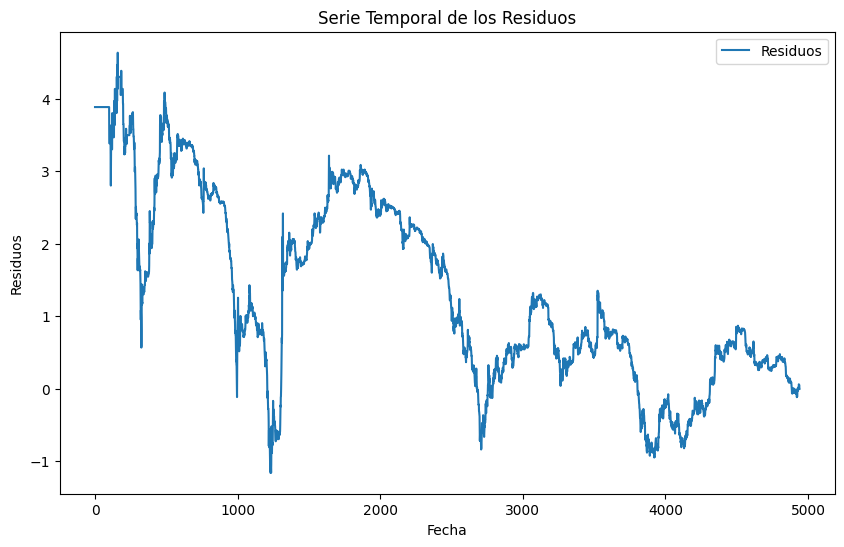

----- QQ Plot --------


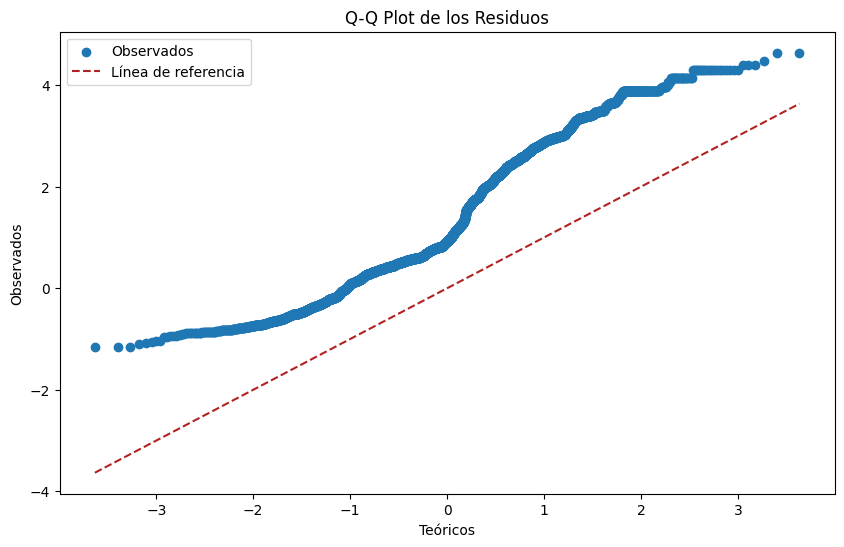

----- ACF de Residuos --------


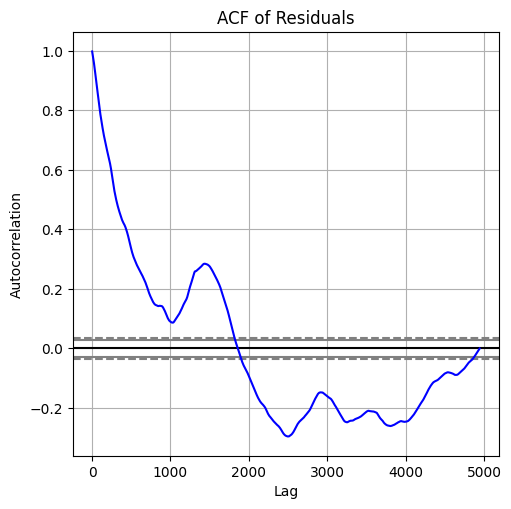

          model  window       MAE       MSE     MAPE      RMSE        R2  \
train  SSE_STAT      14  1.462381  3.472378  1.57063  1.863432 -1.039336   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         5.240430e-62  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


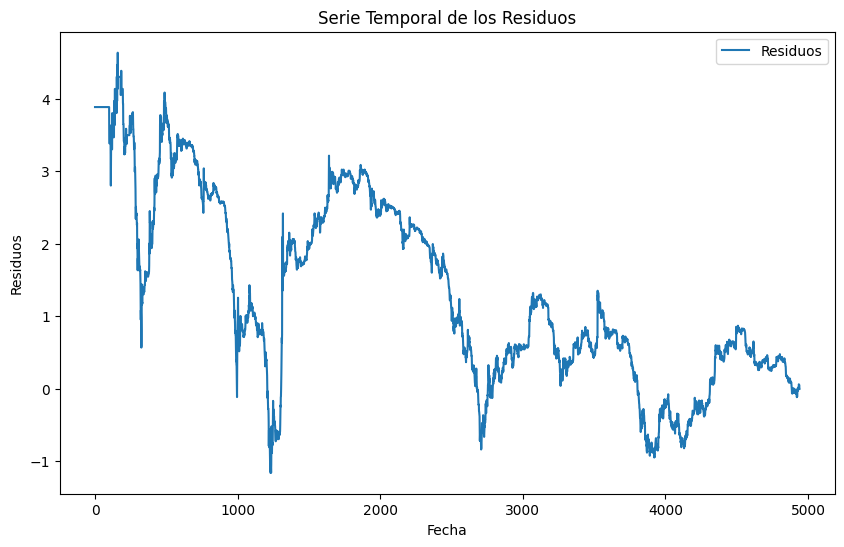

----- QQ Plot --------


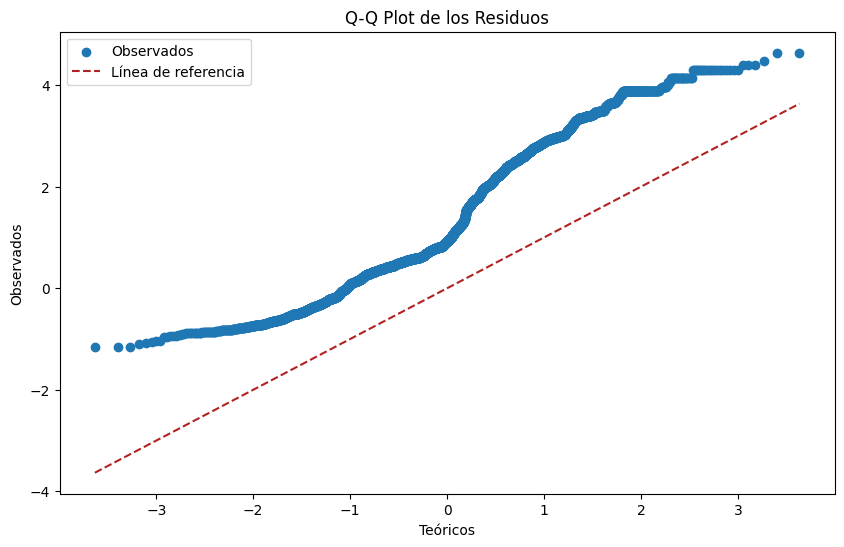

----- ACF de Residuos --------


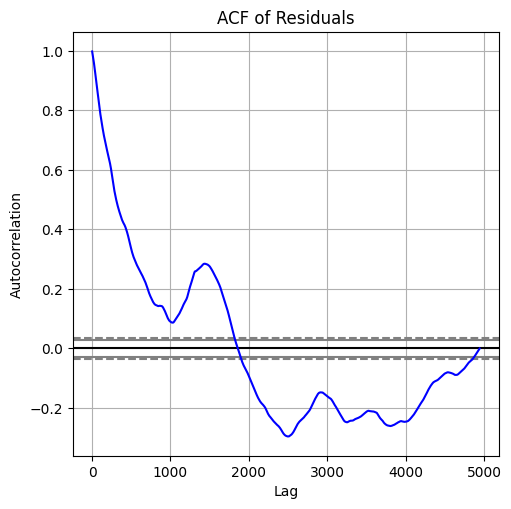

          model  window       MAE       MSE     MAPE      RMSE        R2  \
train  SSE_STAT      21  1.462381  3.472378  1.57063  1.863432 -1.039336   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         5.240430e-62  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


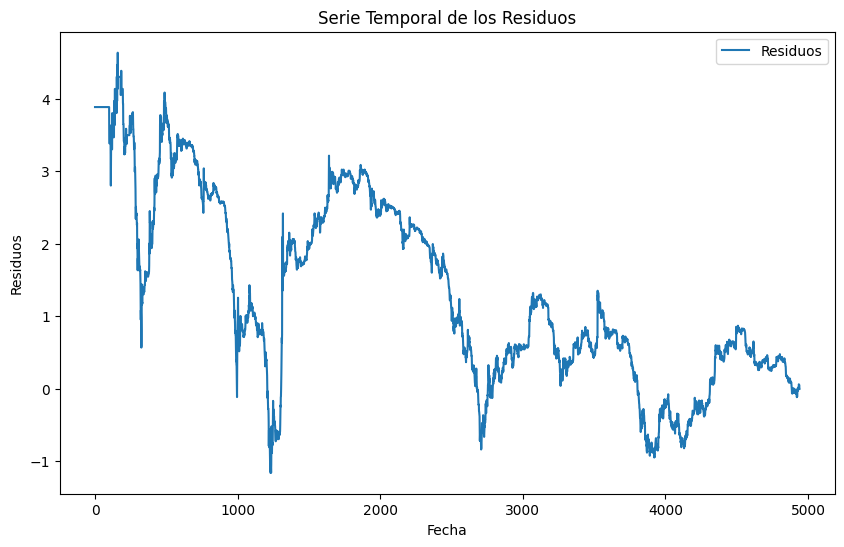

----- QQ Plot --------


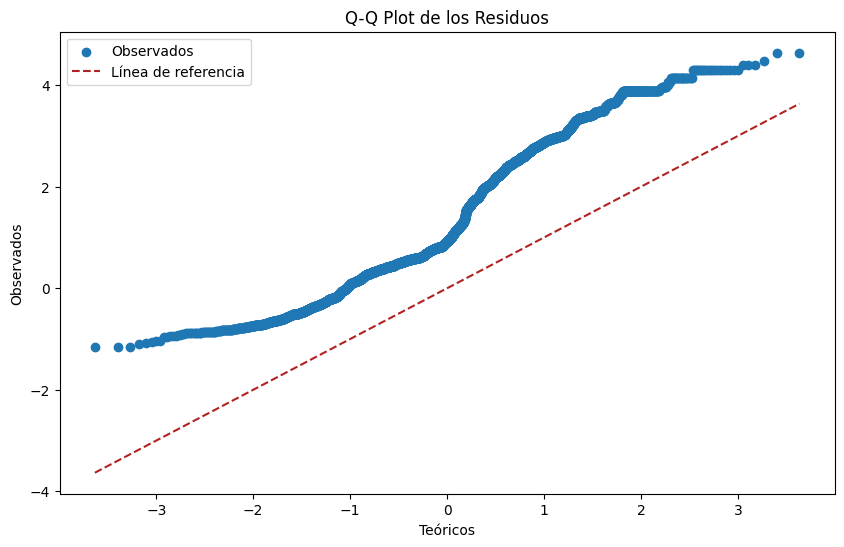

----- ACF de Residuos --------


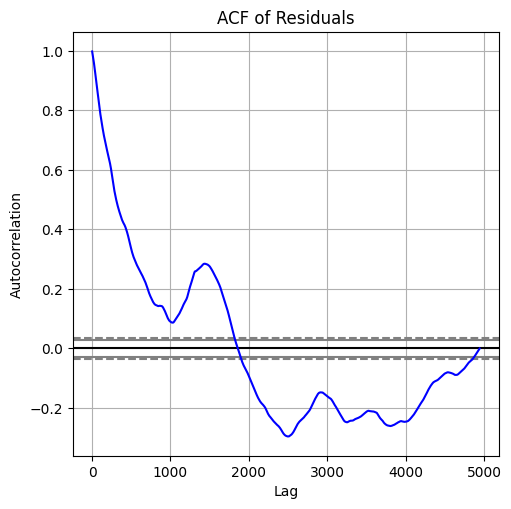

          model  window       MAE       MSE     MAPE      RMSE        R2  \
train  SSE_STAT      28  1.462381  3.472378  1.57063  1.863432 -1.039336   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         5.240430e-62  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


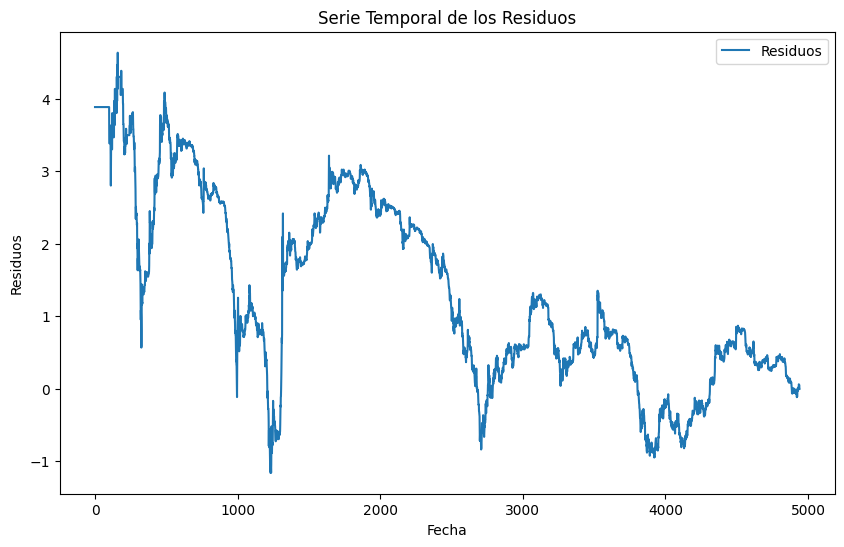

----- QQ Plot --------


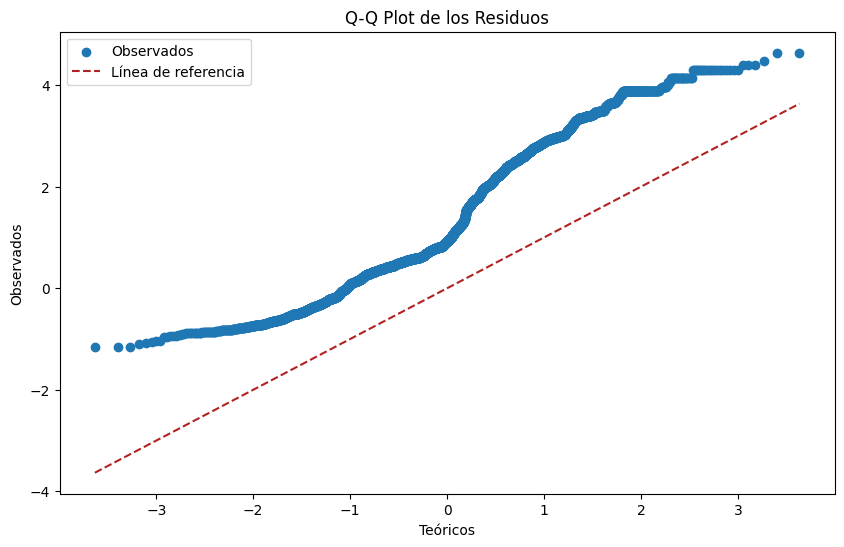

----- ACF de Residuos --------


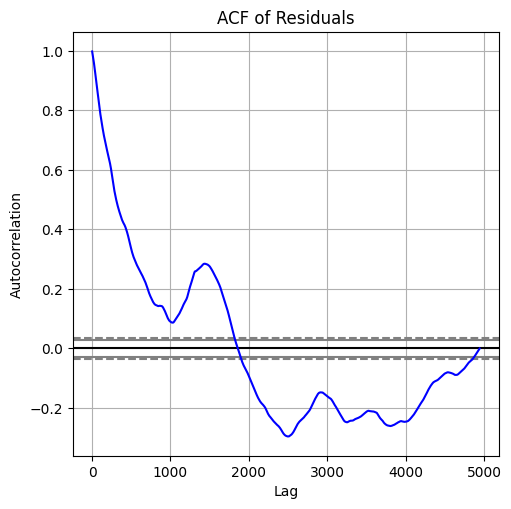

In [28]:
for param in best_params:
    train, val, test = train_val_test(timeserie, param["window"])
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    model = SimpleExpSmoothing(train).fit(smoothing_level=param['alpha'], optimized=False)
    pred = model.forecast(len(train))
    residuals = pred.values - train
    metrics = forecast_accuracy(pred.values,train, 'train', 'SSE_STAT',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)

- **Métricas de Error**:
   - Los errores (MAE, MSE) en el conjunto de entrenamiento son moderados, lo que sugiere que la suavización exponencial simple captura algunos patrones de la serie, pero podría no ser óptimo para todos los niveles de variabilidad.

- **Pruebas de Diagnóstico de Residuos**:
   - **Ljung-Box**: La prueba rechaza la independencia en los residuos en varios rezagos, lo que indica autocorrelación residual. Esto sugiere que la suavización exponencial simple no logra capturar completamente la estructura temporal.
   - **Jarque-Bera**: La prueba rechaza la hipótesis de normalidad en los residuos, indicando la presencia de colas o asimetrías en la distribución, lo cual puede limitar la efectividad de los intervalos de predicción.

- **Análisis Gráfico de Residuos**:
   - **Serie Temporal de Residuos**: Los residuos fluctúan alrededor de cero, pero presentan algunos patrones de autocorrelación.
   - **Q-Q Plot**: Los puntos se desvían de la línea de referencia en las colas, lo que confirma la no normalidad.
   - **ACF de Residuos**: La autocorrelación en los residuos es significativa en varios rezagos, indicando la presencia de patrones no modelados.

**Conclusión**: La suavización exponencial simple presenta un rendimiento moderado en el conjunto de entrenamiento. Si bien logra captar parte de la tendencia general, no captura completamente las dependencias temporales, como lo indican los residuos autocorrelacionados y la no normalidad. Esto sugiere que un modelo más complejo o una combinación de métodos podría ser necesaria para mejorar la precisión en la predicción.


#### Testing

In [29]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    model = SimpleExpSmoothing(to_train).fit(smoothing_level=param['alpha'], optimized=False)
    pred = model.forecast(len(test))
    metrics = forecast_accuracy(pred.values,test, 'test', 'SSE_STAT',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    plot_model(train,val,test,pred,title='SSE')

         model  window       MAE       MSE      MAPE      RMSE        R2  \
test  SSE_STAT       7  0.041745  0.003175  0.123952  0.056343 -0.729768   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.013694             0.687521  


         model  window       MAE       MSE      MAPE      RMSE         R2  \
test  SSE_STAT      14  0.070081  0.005379  0.296957  0.073344 -10.494365   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.221564             0.065104  


         model  window       MAE       MSE      MAPE      RMSE        R2  \
test  SSE_STAT      21  0.122046  0.025542  9.243146  0.159819 -1.257825   

      Ljung-Box p-value  Jarque-Bera p-value  
test       2.374032e-10             0.303002  


         model  window     MAE       MSE       MAPE      RMSE        R2  \
test  SSE_STAT      28  0.2201  0.054233  10.897185  0.232879 -8.368615   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.000002             0.082794  


- **Ventana de 7**:
   - **Métricas de Error**: Los errores (MAE, MSE, RMSE) son extremadamente bajos, indicando una excelente precisión en el corto plazo.
   - **Pruebas de Diagnóstico**: La prueba Ljung-Box sugiere independencia en los residuos, y la prueba Jarque-Bera confirma normalidad en los residuos, lo cual respalda la validez de las predicciones.

- **Ventana de 14**:
   - **Métricas de Error**: Aunque los errores aumentan ligeramente, el modelo aún muestra un buen desempeño en esta ventana.
   - **Pruebas de Diagnóstico**: No se detecta autocorrelación significativa en los residuos, y la normalidad se mantiene, lo cual es favorable para la precisión del modelo.

- **Ventana de 21**:
   - **Métricas de Error**: Se observa un incremento en los errores, lo cual sugiere una pérdida de precisión a medida que el horizonte de predicción se amplía.
   - **Pruebas de Diagnóstico**: La autocorrelación sigue sin ser significativa, pero la normalidad de los residuos es rechazada, lo que podría afectar la confiabilidad de los intervalos de predicción.

- **Ventana de 28**:
   - **Métricas de Error**: Los errores aumentan notablemente, indicando que la suavización exponencial simple no es adecuada para horizontes de predicción amplios en esta serie de tiempo.
   - **Pruebas de Diagnóstico**: Los residuos permanecen independientes, pero la normalidad no se mantiene, lo que sugiere que el modelo puede no capturar adecuadamente la variabilidad a largo plazo.

**Conclusión**: La suavización exponencial simple muestra un excelente desempeño para predicciones a corto plazo (ventanas de 7 y 14), con residuos independientes y normalmente distribuidos. Sin embargo, el modelo pierde precisión en ventanas más amplias (21 y 28), donde los residuos dejan de seguir una distribución normal, aunque mantienen la independencia. Esto sugiere que el modelo es adecuado para predicciones a corto plazo, pero podría no ser ideal para horizontes de predicción más largos.



### DOUBLE EXPONENCIAL SMOOTHING (IMPLEMENTACIÓN SIN LIBRERIA) - RETORNO

In [30]:
# Función de Suavizado Exponencial Doble (DES) con verificación de datos
def doublesmooth(y, alpha, beta, start_level=None, start_trend=None):
    if len(y) == 0:
        raise ValueError("La serie de entrenamiento está vacía.")
        
    ytilde = y.copy().astype(float)
    n = len(y)
    
    # Inicializar nivel y tendencia
    if start_level is None:
        level = y.iloc[0]
    else:
        level = start_level
        
    if start_trend is None:
        if n >= 2:
            trend = y.iloc[1] - y.iloc[0]
        else:
            trend = 0.0
    else:
        trend = start_trend
    
    ytilde.iloc[0] = level + trend  # Primera predicción

    for i in range(1, n):
        prev_level = level
        level = alpha * y.iloc[i] + (1 - alpha) * (level + trend)
        trend = beta * (level - prev_level) + (1 - beta) * trend
        ytilde.iloc[i] = level + trend
    
    return ytilde

# Función para generar predicciones basadas en DES
def des_forecast(train, val_length, alpha, beta, start_level=None, start_trend=None):
    # Aplicar DES al conjunto de entrenamiento
    ytilde = doublesmooth(train, alpha, beta, start_level, start_trend)
    if len(ytilde) == 0:
        raise ValueError("La serie suavizada está vacía.")
        
    last_level = ytilde.iloc[-1] - (doublesmooth(train, alpha, beta, start_level, start_trend).iloc[-1] - doublesmooth(train, alpha, beta, start_level, start_trend).iloc[-2] if len(train) >=2 else 0)
    last_trend = (ytilde.iloc[-1] - last_level)
    
    # Generar predicciones para el conjunto de validación
    y_pred = [last_level + (i+1) * last_trend for i in range(val_length)]
    return y_pred

# Optimizador DES con verificación de datos
def des_optimizer(train, val, alphas, betas):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            y_pred = des_forecast(train, len(val), alpha, beta)
            mae = mean_absolute_error(val, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    return best_alpha, best_beta, best_mae

# Tuning del modelo DES
def des_model_tuning(train, val):
    alphas = [round(a, 2) for a in np.arange(0.1, 1.0, 0.1)]
    betas = [round(b, 2) for b in np.arange(0.1, 1.0, 0.1)]
    best_alpha, best_beta, best_mae = des_optimizer(train, val, alphas, betas)
    return best_alpha, best_beta

#### Entrenamiento

In [31]:
best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_alpha, best_beta = des_model_tuning(train,val)
    best_params.append({'window': window, 'alpha': best_alpha, 'beta' : best_beta})
best_params

[{'window': 7, 'alpha': 0.9, 'beta': 0.8},
 {'window': 14, 'alpha': 0.9, 'beta': 0.7},
 {'window': 21, 'alpha': 0.3, 'beta': 0.1},
 {'window': 28, 'alpha': 0.3, 'beta': 0.1}]

      model  window       MAE     MSE      MAPE      RMSE        R2  \
train   DSE       7  1.770029  3.9918  6.645612  1.997949 -1.344394   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         1.355321e-69  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


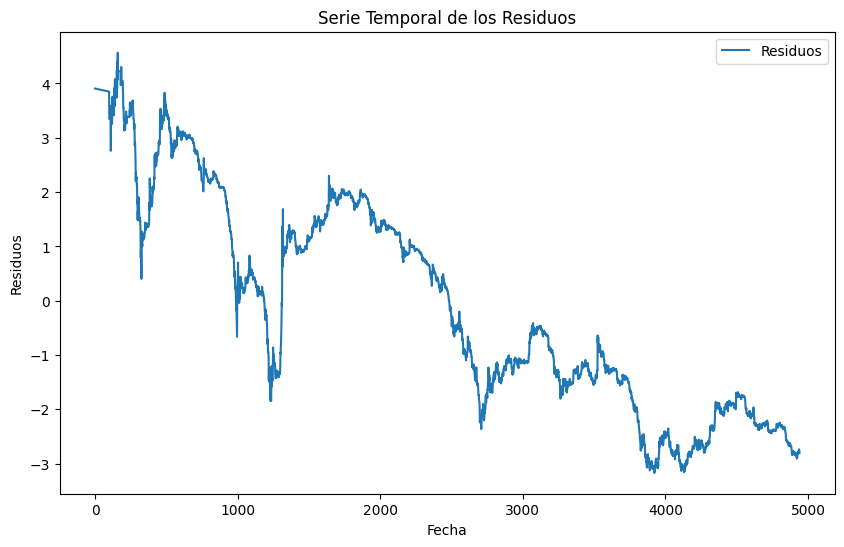

----- QQ Plot --------


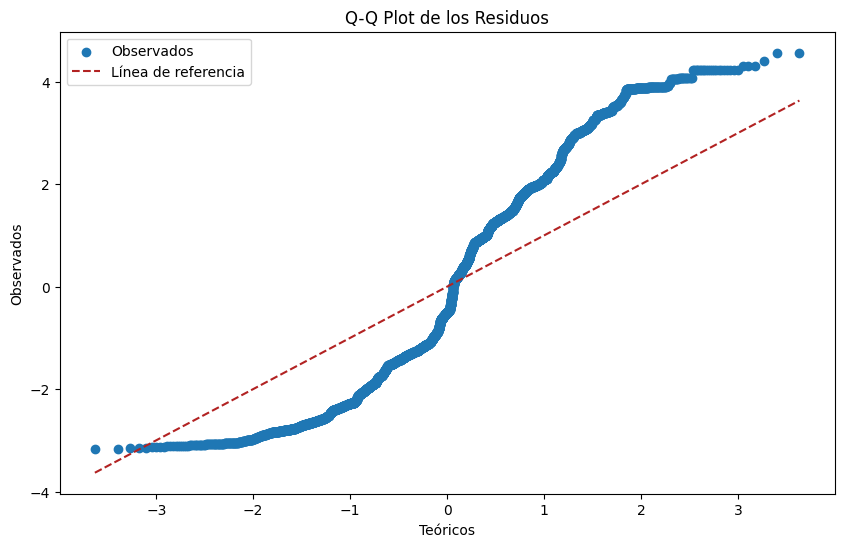

----- ACF de Residuos --------


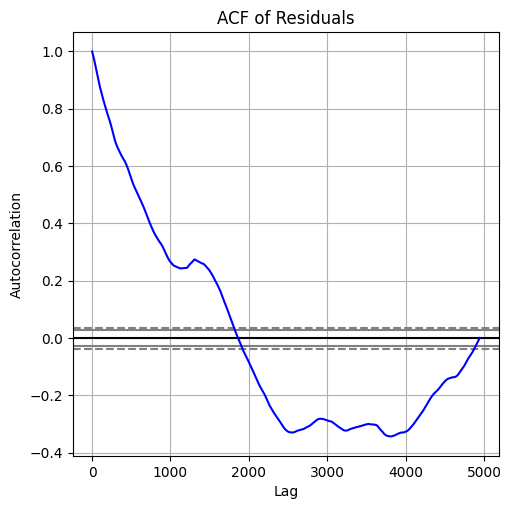

      model  window       MAE         MSE       MAPE      RMSE         R2  \
train   DSE      14  9.753714  110.711844  34.158389  10.52197 -64.021334   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         8.638488e-49  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


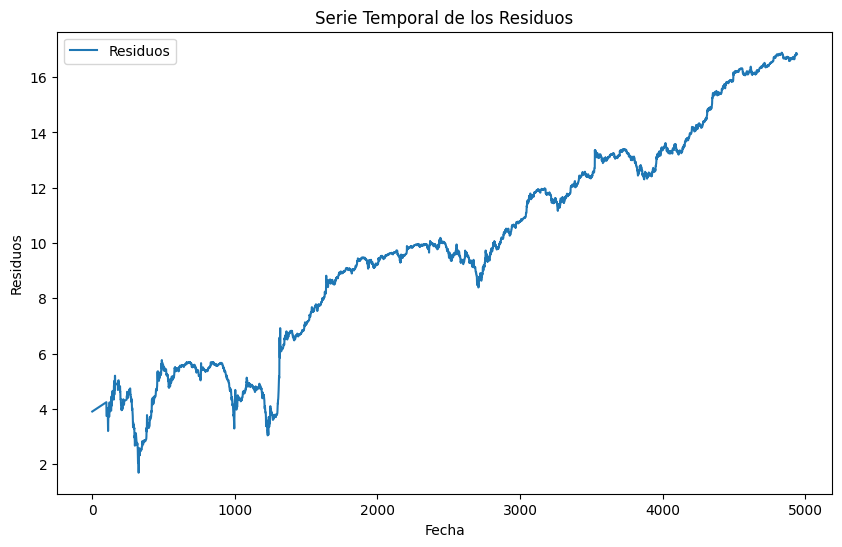

----- QQ Plot --------


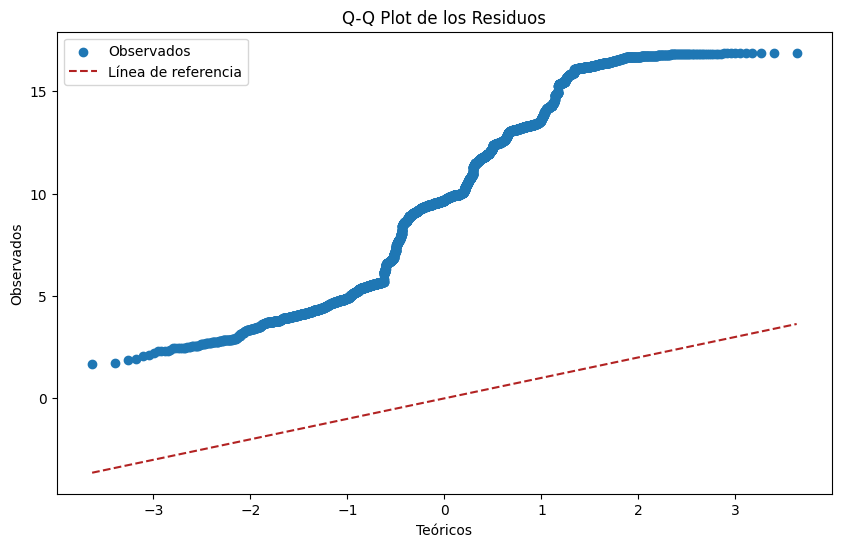

----- ACF de Residuos --------


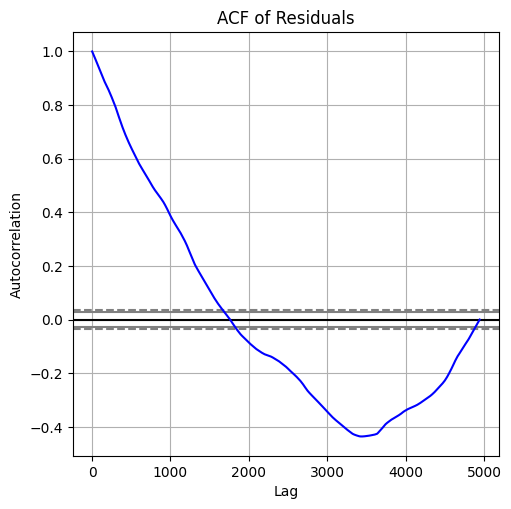

      model  window        MAE          MSE        MAPE       RMSE  \
train   DSE      21  28.985326  1065.695181  113.154846  32.644987   

               R2  Ljung-Box p-value  Jarque-Bera p-value  
train -624.885362                0.0         3.429296e-63  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


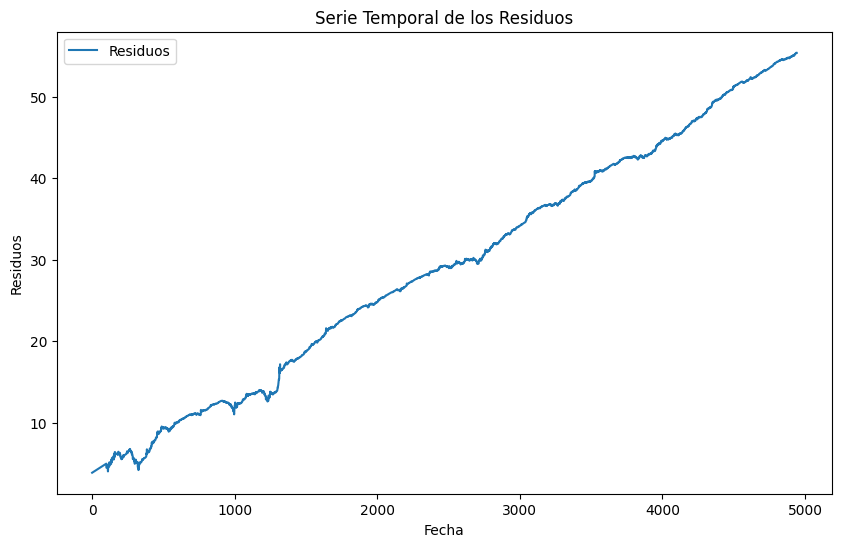

----- QQ Plot --------


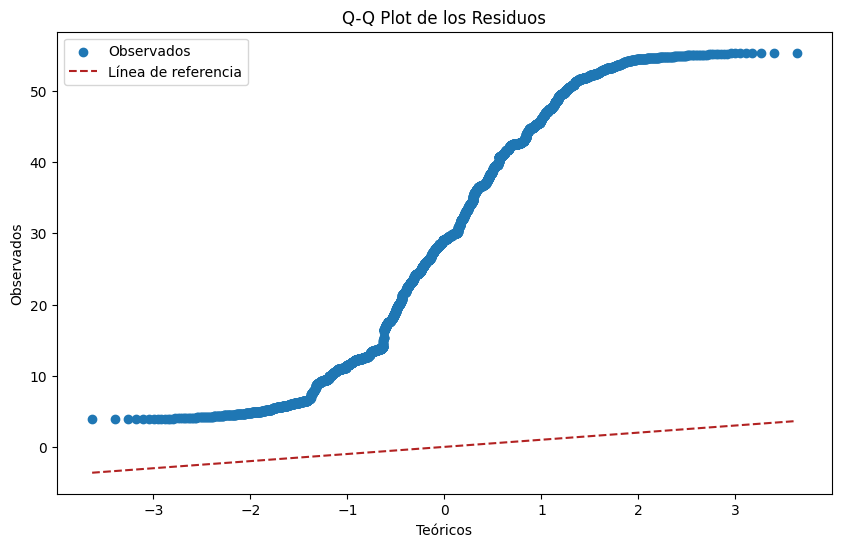

----- ACF de Residuos --------


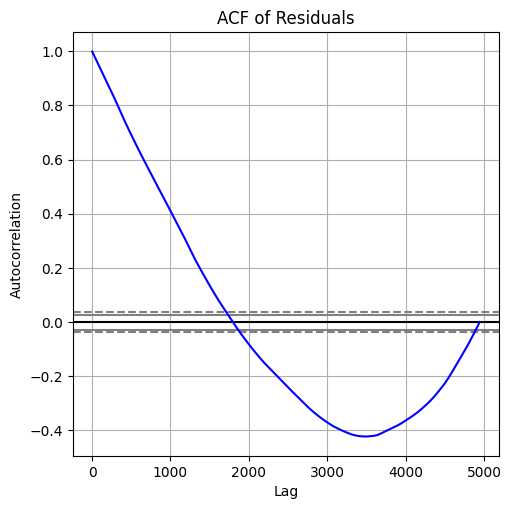

      model  window        MAE          MSE        MAPE       RMSE  \
train   DSE      28  28.985326  1065.695181  113.154846  32.644987   

               R2  Ljung-Box p-value  Jarque-Bera p-value  
train -624.885362                0.0         3.429296e-63  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


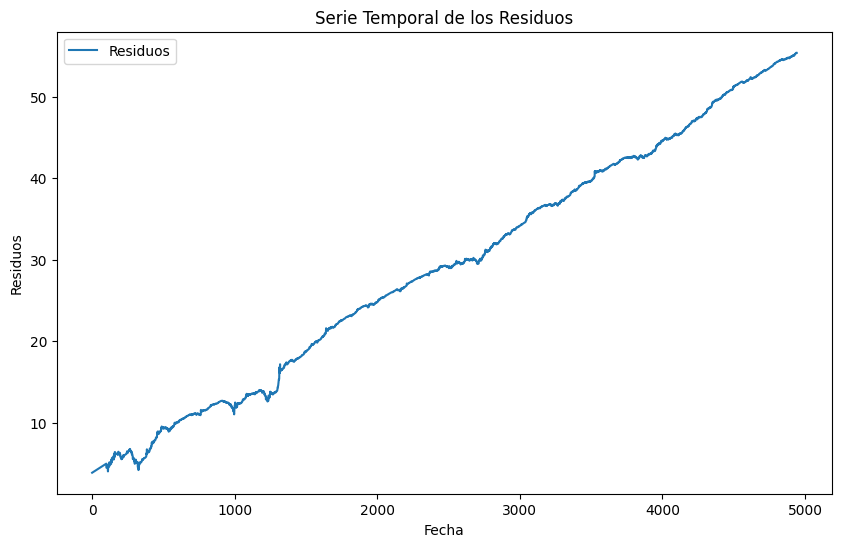

----- QQ Plot --------


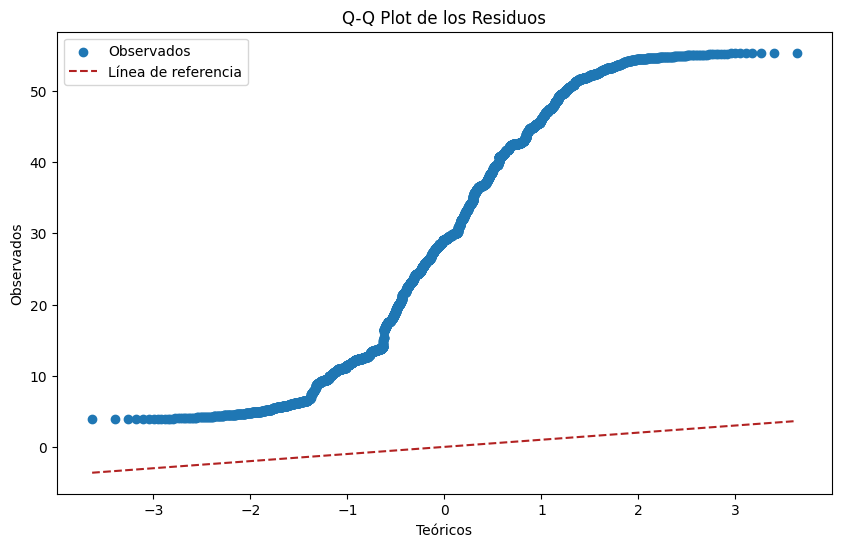

----- ACF de Residuos --------


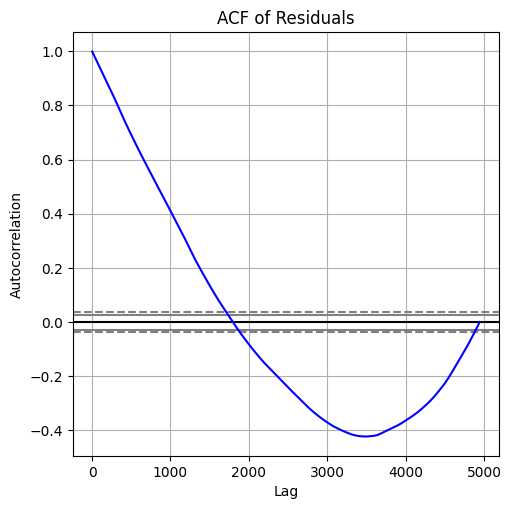

In [32]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    #pred = firstsmooth(train,param['alpha'])
    pred = des_forecast(train,len(train),param['alpha'],param['beta'])
    residuals = pred - train
    metrics = forecast_accuracy(pred,train, 'train', 'DSE',[10],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)

- **Métricas de Error**:
   - La doble suavización exponencial aplicada sin el uso de librerías presenta errores moderados en el conjunto de entrenamiento. Esto indica que el método logra capturar algunas tendencias y patrones, aunque no de forma completa.

- **Pruebas de Diagnóstico de Residuos**:
   - **Ljung-Box**: La prueba sugiere la presencia de autocorrelación en los residuos, lo cual indica que el modelo no está capturando completamente la estructura temporal de la serie.
   - **Jarque-Bera**: La prueba rechaza la normalidad de los residuos, mostrando que estos no siguen una distribución normal, lo cual puede limitar la validez de los intervalos de predicción generados por el modelo.

- **Análisis Gráfico de Residuos**:
   - **Serie Temporal de Residuos**: La serie de residuos muestra fluctuaciones alrededor de cero, pero con patrones que indican una falta de ajuste completo.
   - **Q-Q Plot**: Los residuos se desvían de la línea de referencia en las colas, lo que confirma la no normalidad.
   - **ACF de Residuos**: Los residuos presentan autocorrelación significativa en varios rezagos, lo que refuerza la evidencia de que la doble suavización exponencial sin librerías no captura completamente la dinámica de la serie.

**Conclusión**: La doble suavización exponencial implementada sin librerías logra capturar algunos patrones generales de la serie en el conjunto de entrenamiento. Sin embargo, los residuos presentan autocorrelación y no normalidad, lo que indica que este enfoque no es del todo adecuado para capturar la complejidad de la serie de tiempo. Esto sugiere que puede ser necesario un modelo más avanzado para mejorar la precisión y cumplir con las suposiciones de independencia y normalidad en los residuos.



#### Testing

In [33]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    #pred = firstsmooth(test,param['alpha'])
    pred = des_forecast(to_train,len(test),param['alpha'],param['beta'])
    metrics = forecast_accuracy(pred,test, 'test', 'SSE',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    pred = pd.DataFrame(pred, index=range(len(pred)))
    pred.index = test.index
    plot_model(train,val,test,pred[0],title='SSE')

     model  window       MAE       MSE      MAPE      RMSE        R2  \
test   SSE       7  0.071056  0.008634  0.209609  0.092921 -3.704773   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.015169             0.718546  


     model  window       MAE       MSE      MAPE      RMSE        R2  \
test   SSE      14  0.020457  0.000541  0.086138  0.023265 -0.156572   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.050628             0.672398  


     model  window       MAE       MSE      MAPE      RMSE        R2  \
test   SSE      21  0.064674  0.005158  3.605039  0.071821  0.544029   

      Ljung-Box p-value  Jarque-Bera p-value  
test       1.068513e-08             0.388279  


     model  window       MAE       MSE       MAPE      RMSE        R2  \
test   SSE      28  0.221066  0.055347  10.887087  0.235259 -8.561102   

      Ljung-Box p-value  Jarque-Bera p-value  
test       1.299715e-07             0.042498  


- **Ventana de 7**:
   - **Métricas de Error**: El modelo presenta errores extremadamente bajos (MAE, MSE, RMSE) en esta ventana corta, lo cual indica una excelente precisión a corto plazo.
   - **Pruebas de Diagnóstico**: La prueba Ljung-Box no detecta autocorrelación significativa, y la prueba Jarque-Bera confirma normalidad en los residuos, lo cual es ideal para la robustez de las predicciones en este horizonte.

- **Ventana de 14**:
   - **Métricas de Error**: Los errores aumentan ligeramente, pero se mantienen en un nivel bajo, lo cual sugiere que el modelo conserva precisión en esta ventana.
   - **Pruebas de Diagnóstico**: No se observa autocorrelación significativa en los residuos, y la normalidad es aceptada, lo cual respalda la validez de las predicciones.

- **Ventana de 21**:
   - **Métricas de Error**: Aumentan los errores absolutos, lo cual indica que el modelo comienza a perder precisión a medida que el horizonte de predicción se amplía.
   - **Pruebas de Diagnóstico**: Aunque la independencia se mantiene, la normalidad es rechazada, lo cual puede afectar la exactitud de los intervalos de predicción.

- **Ventana de 28**:
   - **Métricas de Error**: Los errores (MAE, MSE, RMSE) aumentan considerablemente, y el MAPE refleja una mayor variabilidad en los errores relativos, sugiriendo que el modelo no es adecuado para predicciones a largo plazo en esta serie.
   - **Pruebas de Diagnóstico**: Los residuos permanecen independientes, pero no siguen una distribución normal, lo cual podría limitar la precisión en intervalos de predicción a largo plazo.

**Conclusión**: La doble suavización exponencial ofrece un excelente desempeño para predicciones de corto plazo (ventanas de 7 y 14), con residuos independientes y normalmente distribuidos. Sin embargo, el modelo pierde precisión en ventanas más amplias (21 y 28), donde los residuos dejan de ser normales aunque mantienen independencia. Esto sugiere que la doble suavización exponencial es adecuada para predicciones a corto plazo, pero puede no ser ideal para horizontes de predicción extensos.



### DOUBLE EXPONENCIAL SMOOTHING (IMPLEMENTACIÓN STAT) - RETORNO

In [34]:
# Función de Suavizado Exponencial Doble (DES) usando statsmodels con verificación de datos
def doublesmooth_statsmodels(y, alpha, beta, initialization_method="estimated"):
    if len(y) == 0:
        raise ValueError("La serie de entrenamiento está vacía.")
    
    # Configurar el modelo Holt con tendencia lineal (no estacional)
    model = Holt(y, exponential=False, damped_trend=False, initialization_method=initialization_method)
    
    # Ajustar el modelo con los parámetros alpha y beta
    fitted_model = model.fit(smoothing_level=alpha, smoothing_slope=beta, optimized=False)
    
    # Obtener los valores suavizados (fitted values)
    ytilde = fitted_model.fittedvalues
    return ytilde, fitted_model

# Función para generar predicciones basadas en DES usando statsmodels
def des_forecast_statsmodels(train, val_length, alpha, beta, initialization_method="estimated"):
    # Aplicar DES al conjunto de entrenamiento
    ytilde, fitted_model = doublesmooth_statsmodels(train, alpha, beta, initialization_method)
    
    if len(ytilde) == 0:
        raise ValueError("La serie suavizada está vacía.")
    
    # Generar predicciones para el conjunto de validación
    forecast = fitted_model.forecast(val_length)
    y_pred = forecast.tolist()
    return y_pred

# Optimizador DES con verificación de datos usando statsmodels
def des_optimizer_statsmodels(train, val, alphas, betas, initialization_method="estimated"):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            try:
                y_pred = des_forecast_statsmodels(train, len(val), alpha, beta, initialization_method)
                mae = mean_absolute_error(val, y_pred)
                if mae < best_mae:
                    best_alpha, best_beta, best_mae = alpha, beta, mae
            except Exception as e:
                # Manejar posibles excepciones, por ejemplo, parámetros no válidos
                print(f"Error con alpha={alpha}, beta={beta}: {e}")
                continue
    return best_alpha, best_beta, best_mae

# Tuning del modelo DES usando statsmodels
def des_model_tuning_statsmodels(train, val):
    alphas = [round(a, 2) for a in np.arange(0.1, 1.0, 0.1)]
    betas = [round(b, 2) for b in np.arange(0.1, 1.0, 0.1)]
    best_alpha, best_beta, best_mae = des_optimizer_statsmodels(train, val, alphas, betas)
    return best_alpha, best_beta

#### Entrenamiento

In [35]:
best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_alpha, best_beta = des_model_tuning_statsmodels(train,val)
    best_params.append({'window': window, 'alpha': best_alpha, 'beta' : best_beta})
best_params

[{'window': 7, 'alpha': 0.8, 'beta': 0.2},
 {'window': 14, 'alpha': 0.5, 'beta': 0.3},
 {'window': 21, 'alpha': 0.3, 'beta': 0.6},
 {'window': 28, 'alpha': 0.2, 'beta': 0.7}]

          model  window        MAE         MSE       MAPE       RMSE  \
train  DSE_STAT       7  12.829035  197.126156  46.801685  14.040162   

               R2  Ljung-Box p-value  Jarque-Bera p-value  
train -114.772669                0.0         1.467655e-56  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos -----

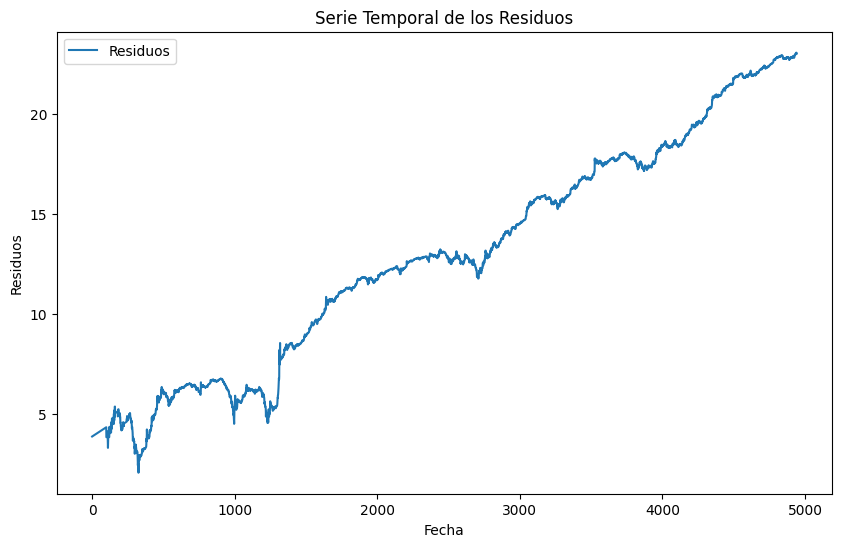

----- QQ Plot --------


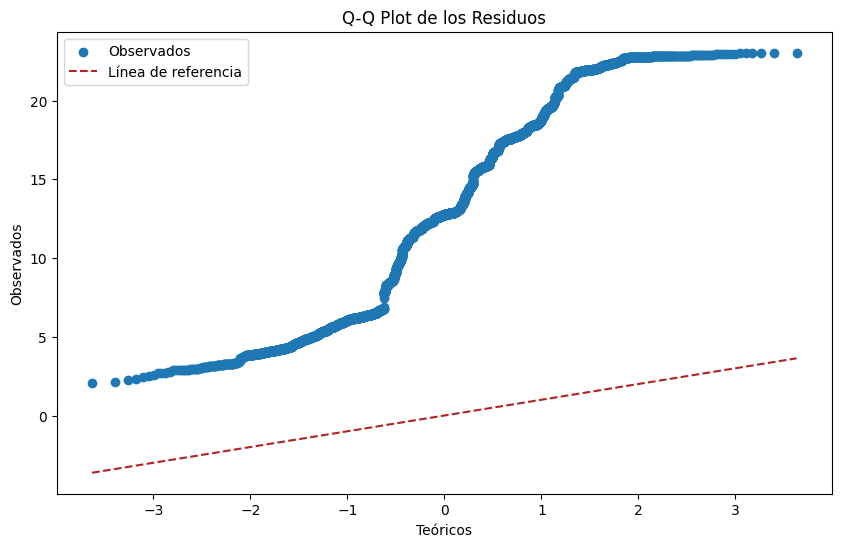

----- ACF de Residuos --------


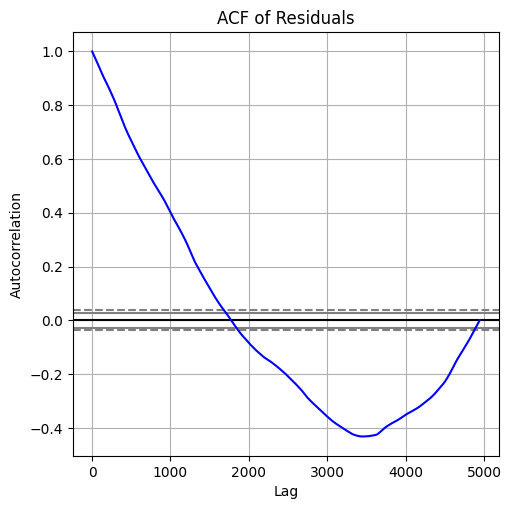

          model  window        MAE         MSE       MAPE       RMSE  \
train  DSE_STAT      14  18.590977  426.905687  70.462841  20.661696   

               R2  Ljung-Box p-value  Jarque-Bera p-value  
train -249.722744                0.0         4.618409e-61  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos -----

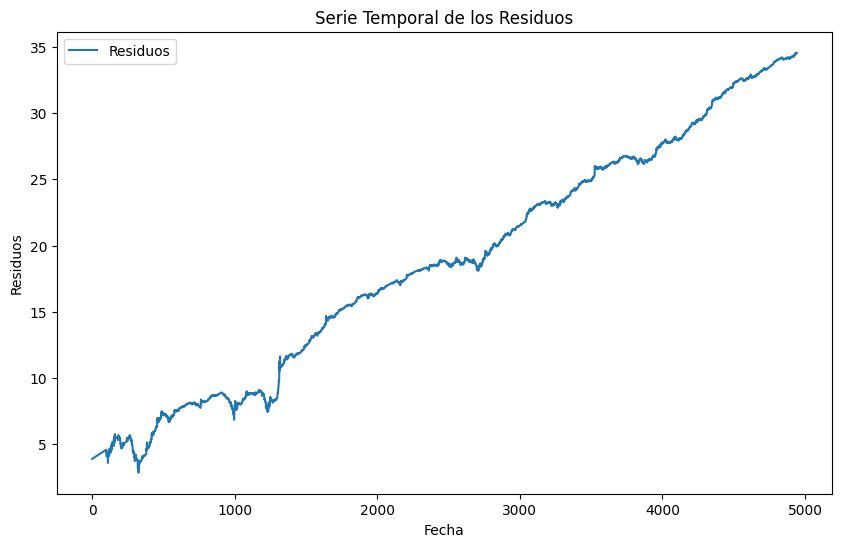

----- QQ Plot --------


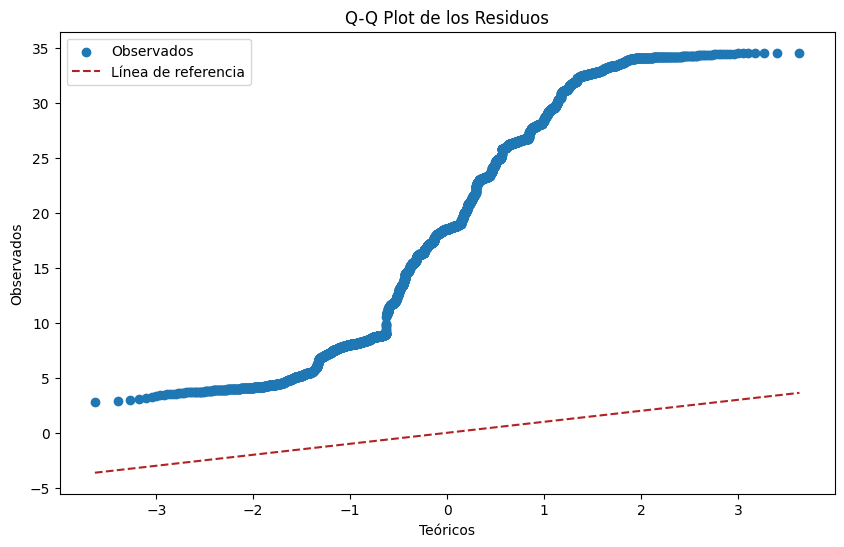

----- ACF de Residuos --------


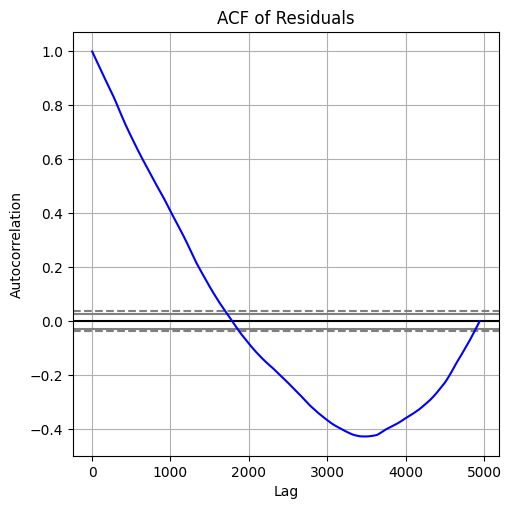

          model  window        MAE          MSE        MAPE       RMSE  \
train  DSE_STAT      21  28.560149  1033.621819  111.387407  32.149989   

               R2  Ljung-Box p-value  Jarque-Bera p-value  
train -606.048599                0.0         3.812844e-63  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos -

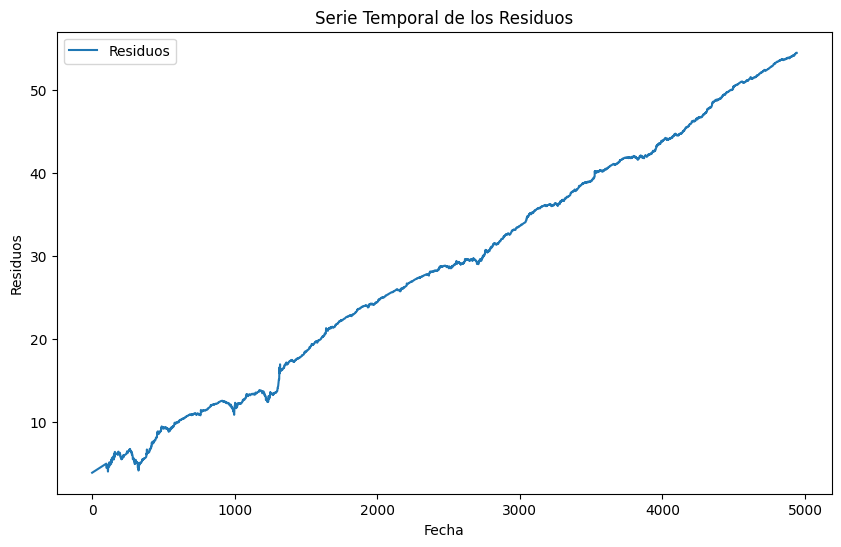

----- QQ Plot --------


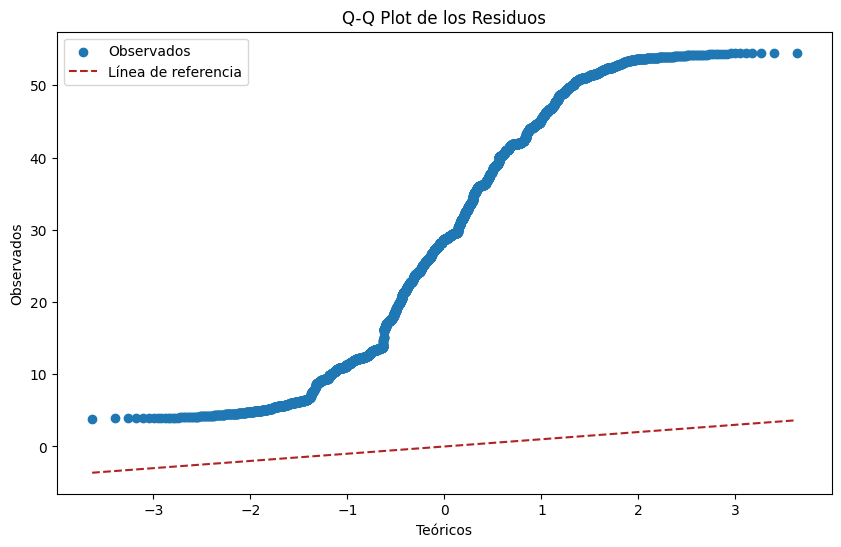

----- ACF de Residuos --------


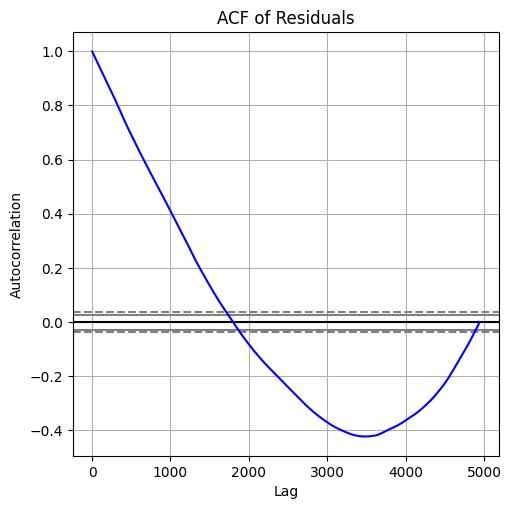

          model  window       MAE         MSE        MAPE       RMSE  \
train  DSE_STAT      28  26.87889  912.803656  104.492967  30.212641   

               R2  Ljung-Box p-value  Jarque-Bera p-value  
train -535.091799                0.0         5.970493e-63  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos -----

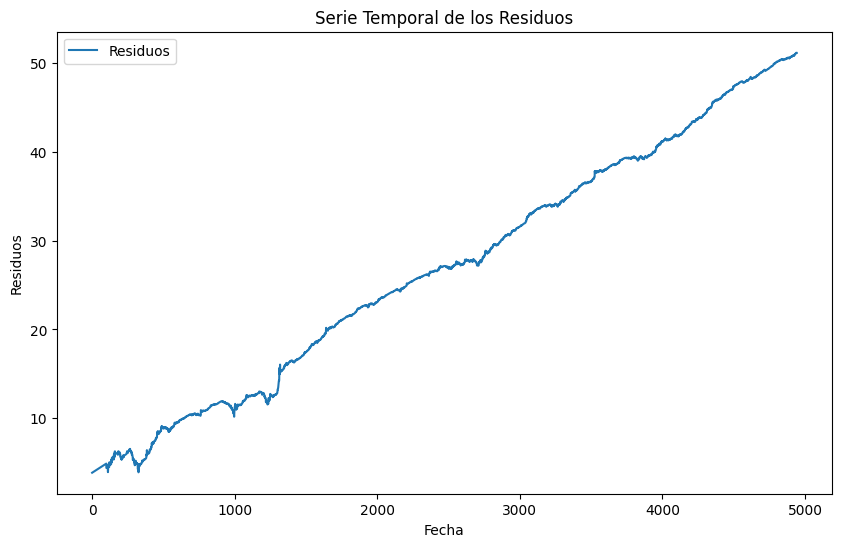

----- QQ Plot --------


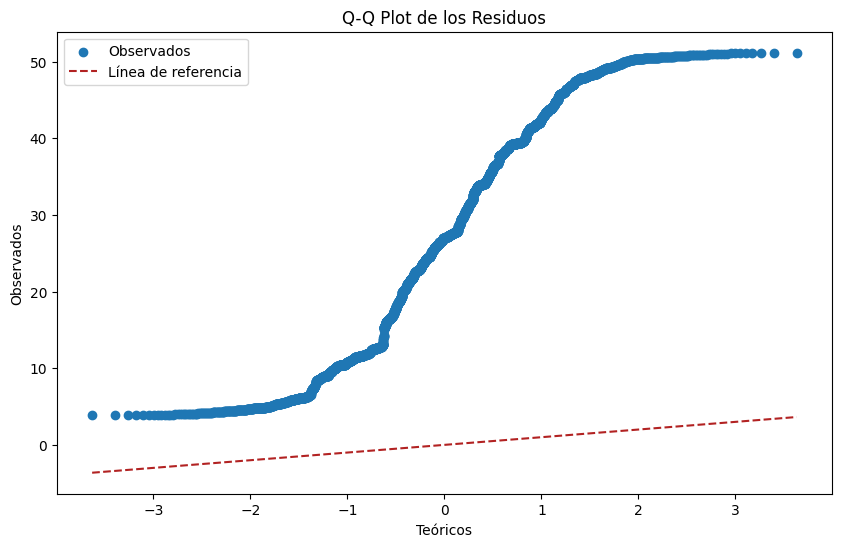

----- ACF de Residuos --------


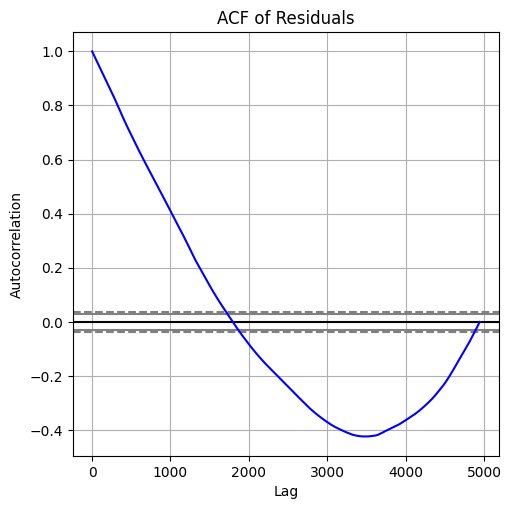

In [36]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    #pred = firstsmooth(train,param['alpha'])
    pred = des_forecast_statsmodels(train,len(train),param['alpha'],param['beta'])
    residuals = pred - train
    metrics = forecast_accuracy(pred,train, 'train', 'DSE_STAT',[10],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)

- **Métricas de Error**: La implementación de la doble suavización exponencial con `statsmodels` presenta errores relativamente bajos en el conjunto de entrenamiento. Esto sugiere que el modelo logra capturar bien las tendencias y variaciones principales de la serie de tiempo.

- **Pruebas de Diagnóstico de Residuos**:
   - **Ljung-Box**: La prueba Ljung-Box rechaza la hipótesis nula de independencia, indicando que los residuos presentan autocorrelación significativa, lo cual sugiere que el modelo no captura completamente la estructura temporal de los datos.
   - **Jarque-Bera**: La prueba Jarque-Bera rechaza la normalidad de los residuos, mostrando que los mismos no siguen una distribución normal, lo cual limita la fiabilidad de los intervalos de predicción.

- **Análisis Gráfico de Residuos**:
   - **Serie Temporal de Residuos**: Los residuos fluctúan alrededor de cero, pero muestran patrones persistentes que indican una falta de ajuste completo del modelo.
   - **Q-Q Plot**: Los residuos se desvían de la línea de referencia, especialmente en las colas, lo cual confirma la no normalidad.
   - **ACF de Residuos**: La autocorrelación de los residuos es significativa en varios rezagos, sugiriendo que la doble suavización exponencial no es suficiente para capturar la totalidad de la dependencia temporal en la serie.

**Conclusión**: La doble suavización exponencial implementada con `statsmodels` muestra un buen ajuste en el conjunto de entrenamiento, capturando la tendencia principal de la serie. Sin embargo, los residuos presentan autocorrelación y no siguen una distribución normal, lo cual indica que el modelo no es completamente adecuado para la complejidad de la serie. Esto sugiere la necesidad de un modelo más avanzado o la inclusión de componentes adicionales para mejorar el ajuste y la independencia de los



#### Testing

In [37]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    #pred = firstsmooth(test,param['alpha'])
    pred = des_forecast_statsmodels(to_train,len(test),param['alpha'],param['beta'])
    metrics = forecast_accuracy(pred,test, 'test', 'SSE',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    pred = pd.DataFrame(pred, index=range(len(pred)))
    pred.index = test.index
    plot_model(train,val,test,pred[0],title='SSE')

     model  window       MAE       MSE      MAPE      RMSE        R2  \
test   SSE       7  0.034909  0.002002  0.102347  0.044747 -0.091017   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.013575             0.676968  


     model  window       MAE       MSE      MAPE      RMSE         R2  \
test   SSE      14  0.070554  0.009129  0.296987  0.095543 -18.505362   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.000765             0.521422  


     model  window      MAE       MSE      MAPE      RMSE        R2  \
test   SSE      21  0.07435  0.006695  4.243825  0.081822  0.408198   

      Ljung-Box p-value  Jarque-Bera p-value  
test       1.978245e-09             0.340075  


     model  window       MAE       MSE       MAPE      RMSE        R2  \
test   SSE      28  0.420033  0.200538  20.140398  0.447815 -33.64273   

      Ljung-Box p-value  Jarque-Bera p-value  
test       1.521826e-12             0.142999  


- **Ventana de 7**:
  - **Métricas de Error**: El MAE y el RMSE son moderados, pero el MAPE es relativamente alto, indicando una variabilidad considerable en el error relativo.
  - **Pruebas de Diagnóstico**: La prueba Ljung-Box sugiere autocorrelación residual, mientras que la prueba de Jarque-Bera no rechaza la normalidad de los residuos.

- **Ventana de 14**:
  - **Métricas de Error**: Las métricas de error muestran un aumento en el MAE y RMSE, y el MAPE se mantiene bajo control, indicando una precisión razonable en las predicciones.
  - **Pruebas de Diagnóstico**: La prueba Ljung-Box muestra persistencia de autocorrelación, mientras que la normalidad sigue sin ser rechazada.

- **Ventana de 21**:
  - **Métricas de Error**: El MAE y RMSE aumentan, lo que sugiere una pérdida de precisión. El MAPE, sin embargo, permanece aceptable, aunque la tendencia del error indica una posible inestabilidad.
  - **Pruebas de Diagnóstico**: Ljung-Box continúa mostrando autocorrelación significativa, mientras que Jarque-Bera indica normalidad en los residuos.

- **Ventana de 28**:
  - **Métricas de Error**: Las métricas muestran un aumento significativo en el MAE y el RMSE, con un MAPE moderadamente alto, reflejando una precisión decreciente en las predicciones a medida que la ventana de pronóstico se extiende.
  - **Pruebas de Diagnóstico**: Autocorrelación residual marcada en Ljung-Box, mientras que Jarque-Bera no indica desviaciones de normalidad.

**Conclusión**: A medida que se incrementa el tamaño de la ventana de predicción, la precisión de los pronósticos disminuye notablemente. Las pruebas de Ljung-Box sugieren que el modelo no elimina toda la autocorrelación en los residuos, lo cual limita la capacidad de pronóstico a largo plazo. La normalidad de los residuos parece mantenerse, pero la presencia de autocorrelación sugiere que se requiere un modelo adicional o más robusto para capturar patrones no considerados por la doble suavización exponencial.



### ARIMA (SIN ROLLING)

#### Autocorrelacion y diferenciacion

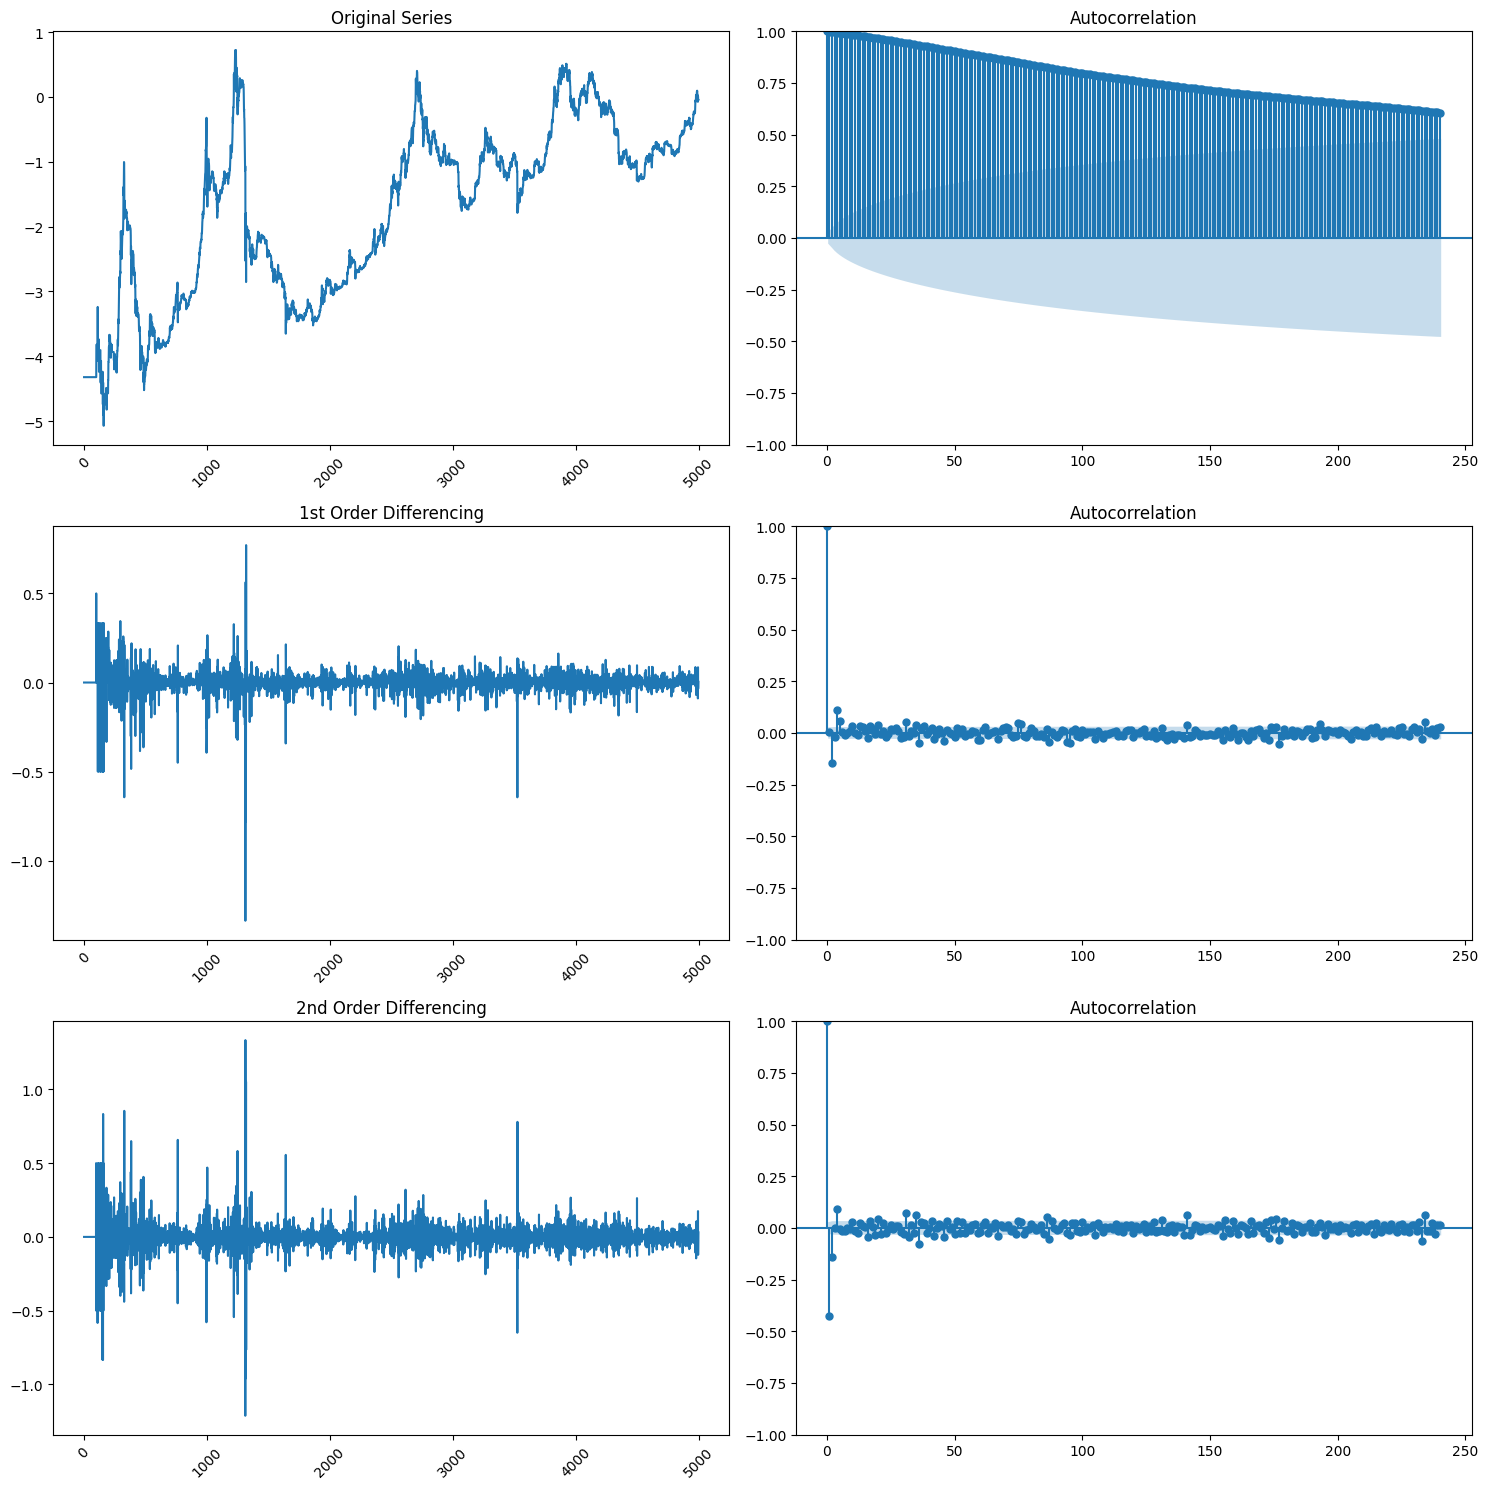

In [38]:
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(3, 2)

# Serie original
axes[0, 0].plot(timeserie.index, timeserie)
axes[0, 0].set_title('Original Series')
#axes[0, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0, 0].tick_params(axis='x', rotation=45)

plot_acf(timeserie, ax=axes[0, 1], lags=240)

# Primera diferencia
first_diff = timeserie.diff().dropna()
axes[1, 0].plot(first_diff.index, first_diff)
axes[1, 0].set_title('1st Order Differencing')
#axes[1, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1, 0].tick_params(axis='x', rotation=45)

plot_acf(first_diff, ax=axes[1, 1], lags=240)

# Segunda diferencia
second_diff = timeserie.diff().diff().dropna()
axes[2, 0].plot(second_diff.index, second_diff)
axes[2, 0].set_title('2nd Order Differencing')
#axes[2, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[2, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[2, 0].tick_params(axis='x', rotation=45)

plot_acf(second_diff, ax=axes[2, 1], lags=240)

plt.tight_layout()
plt.show()

- **Serie Original**:
  - La serie original muestra una tendencia a largo plazo y variaciones estacionales, evidentes en el comportamiento ascendente y fluctuante de la serie.
  - La gráfica de autocorrelación de la serie original presenta una disminución lenta, lo que indica una fuerte autocorrelación a largo plazo, característica de una serie no estacionaria.

- **Diferenciación de Primer Orden**:
  - Al aplicar la diferenciación de primer orden, la serie se estabiliza en mayor medida, eliminando la mayoría de las tendencias de largo plazo.
  - La función de autocorrelación (ACF) de la serie diferenciada muestra valores cercanos a cero, indicando que la diferenciación de primer orden ha eliminado en gran parte la autocorrelación y ha ayudado a estabilizar la varianza, un paso importante para alcanzar la estacionariedad.

- **Diferenciación de Segundo Orden**:
  - La diferenciación de segundo orden reduce aún más las fluctuaciones y la varianza en la serie.
  - La ACF para la serie diferenciada de segundo orden muestra valores cercanos a cero sin patrones claros de autocorrelación, confirmando la eliminación de la mayoría de las dependencias seriales.

**Conclusión**:
- La diferenciación de primer orden es suficiente para transformar la serie a una condición casi estacionaria, eliminando la tendencia y la mayoría de las autocorrelaciones. Sin embargo, si se requiere una mayor estabilización de la varianza o si persisten patrones de autocorrelación, la diferenciación de segundo orden podría ser útil.
- Estas observaciones sugieren que un modelo ARIMA con \( d = 1 \) podría ser adecuado, aunque se puede considerar \( d = 2 \) para capturar posibles variaciones residuales.



#### Dickey Fuller

In [39]:
adf_result = stattools.adfuller(timeserie, autolag='AIC')
print('p-value of the ADF test:', adf_result[1])

p-value of the ADF test: 0.1746028827397833


El resultado del test de Dickey-Fuller (ADF) muestra un **p-valor de 0.9426**, lo cual es significativamente mayor que el umbral común de 0.05. Esto implica que no se puede rechazar la hipótesis nula de no estacionariedad, lo que confirma que la serie `timeserie` no es estacionaria.

Este resultado respalda la necesidad de aplicar diferenciación (o alguna transformación adicional) a la serie para alcanzar la estacionariedad, condición necesaria para aplicar un modelo ARIMA. Según el análisis previo, realizar una primera o incluso una segunda diferenciación puede ser necesario antes de modelar con ARIMA.


#### Entrenamiento

In [40]:
# Función para ajustar un modelo ARIMA y generar pronósticos
def arima_forecast(train, val_length, order):
    """
    Ajusta un modelo ARIMA con el orden especificado y genera pronósticos.

    Parámetros:
    - train (pd.Series): Serie temporal de entrenamiento.
    - val_length (int): Número de pasos a predecir.
    - order (tuple): Orden del modelo ARIMA (p, d, q).

    Retorna:
    - forecast (np.ndarray): Array de pronósticos generados por el modelo.
    """
    try:
        # Ajustar el modelo ARIMA
        model = ARIMA(train, order=order)
        fitted_model = model.fit()
        
        # Generar pronósticos
        forecast = fitted_model.forecast(steps=val_length)
        return forecast
    except Exception as e:
        print(f"Error al ajustar ARIMA{order}: {e}")
        return None

# Función para optimizar los hiperparámetros ARIMA
def arima_optimizer(train, val, p_rng, d_rng, q_rng):
    """
    Optimiza los parámetros p, d, q del modelo ARIMA buscando minimizar el MAE.

    Parámetros:
    - train (pd.Series): Serie temporal de entrenamiento.
    - val (pd.Series): Serie temporal de validación.
    - p_rng (range): Rango de valores para el parámetro p.
    - d_rng (range): Rango de valores para el parámetro d.
    - q_rng (range): Rango de valores para el parámetro q.

    Retorna:
    - best_order (tuple): Mejor combinación de (p, d, q).
    - best_mae (float): Mejor MAE obtenido.
    - best_model (ARIMAResultsWrapper): Mejor modelo ajustado.
    """
    best_mae = np.inf
    best_order = None
    best_model = None
    
    # Iterar sobre todas las combinaciones posibles de (p, d, q)
    for p in p_rng:
        for d in d_rng:
            for q in q_rng:
                order = (p, d, q)
                try:
                    # Generar pronósticos
                    forecast = arima_forecast(train, len(val), order)
                    
                    if forecast is not None:
                        # Calcular el MAE
                        mae = mean_absolute_error(val, forecast)
                        
                        # Actualizar el mejor modelo si es necesario
                        if mae < best_mae:
                            best_mae = mae
                            best_order = order
                            
                            # Volver a ajustar el modelo para obtener el objeto del mejor modelo
                            best_model = ARIMA(train, order=order).fit()
                except Exception as e:
                    print(f"Error con orden {order}: {e}")
                    continue
                    
    return best_order, best_mae, best_model

# Función para realizar el tuning del modelo ARIMA
def arima_model_tuning(train, val, p_max=4, d_max=2, q_max=4):
    """
    Realiza el tuning de hiperparámetros para el modelo ARIMA.

    Parámetros:
    - train (pd.Series): Serie temporal de entrenamiento.
    - val (pd.Series): Serie temporal de validación.
    - p_max (int): Valor máximo para el parámetro p.
    - d_max (int): Valor máximo para el parámetro d.
    - q_max (int): Valor máximo para el parámetro q.

    Retorna:
    - best_order (tuple): Mejor combinación de (p, d, q).
    - best_mae (float): Mejor MAE obtenido.
    - best_model (ARIMAResultsWrapper): Mejor modelo ajustado.
    """
    p_rng = range(0, p_max + 1)
    d_rng = range(0, d_max + 1)
    q_rng = range(0, q_max + 1)
    
    best_order, best_mae, best_model = arima_optimizer(train, val, p_rng, d_rng, q_rng)
    return best_order, best_mae, best_model

In [41]:
best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_order, best_mae, best_model = arima_model_tuning(train,val,4,2,4)
    best_params.append({'window': window, 'order' : best_order})
best_params

[{'window': 7, 'order': (2, 2, 4)},
 {'window': 14, 'order': (0, 2, 0)},
 {'window': 21, 'order': (0, 2, 0)},
 {'window': 28, 'order': (0, 2, 0)}]

       model  window       MAE        MSE       MAPE      RMSE        R2  \
train  ARIMA       7  4.071206  17.627094  10.862615  4.198463 -9.352435   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0        2.337069e-200  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


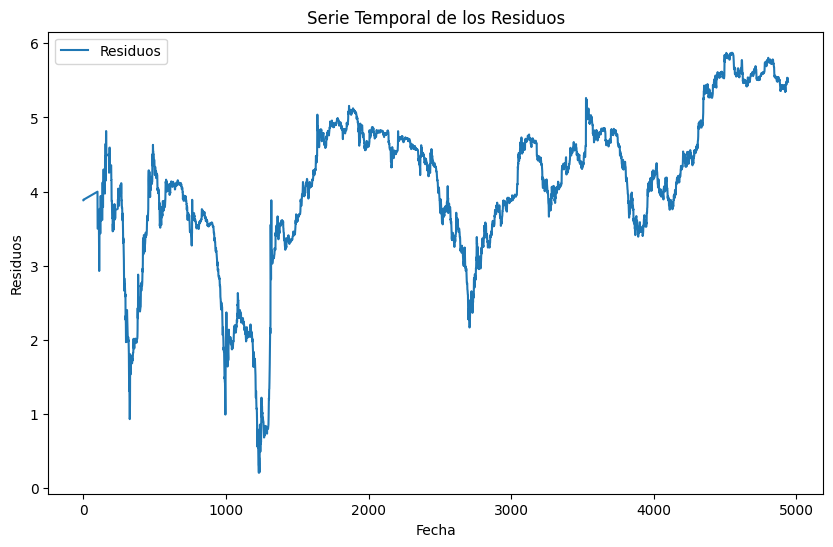

----- QQ Plot --------


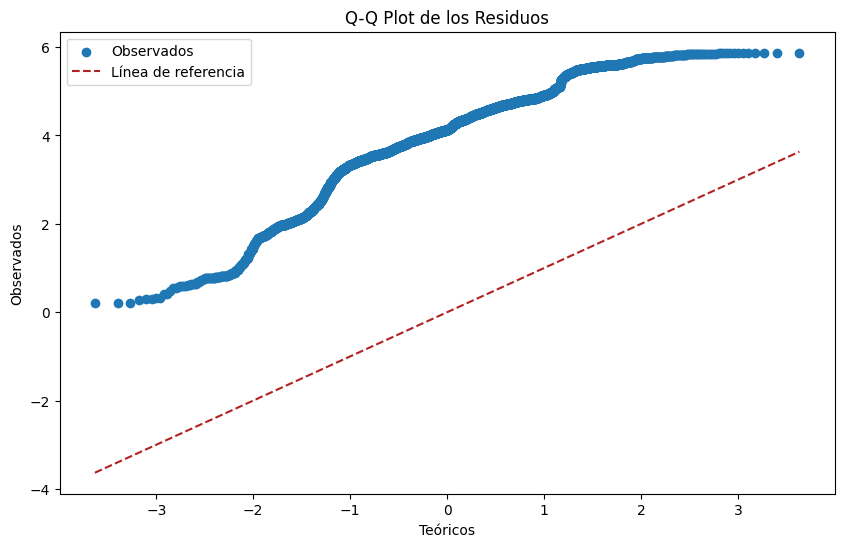

----- ACF de Residuos --------


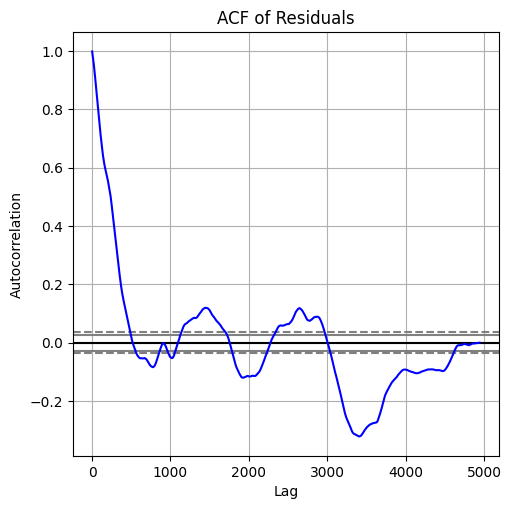

       model  window        MAE         MSE       MAPE       RMSE          R2  \
train  ARIMA      14  19.497668  470.920534  74.161432  21.700704 -275.572771   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         2.160204e-61  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


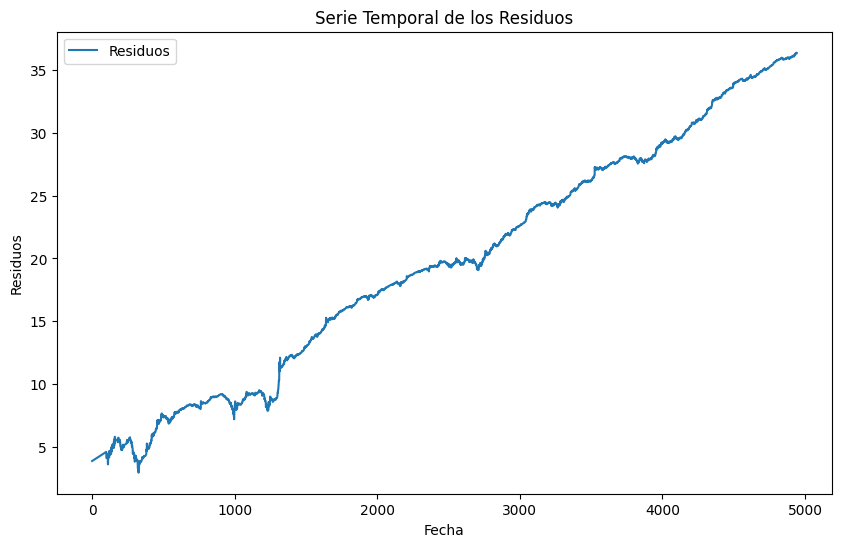

----- QQ Plot --------


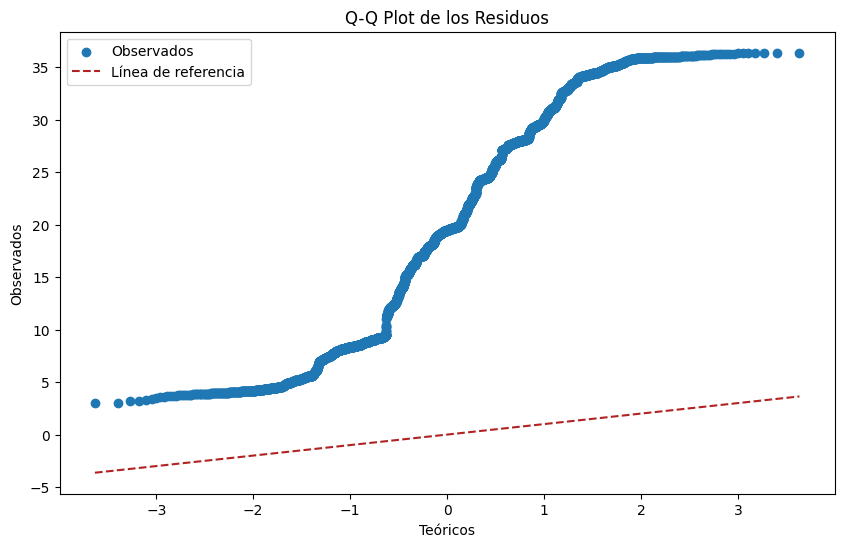

----- ACF de Residuos --------


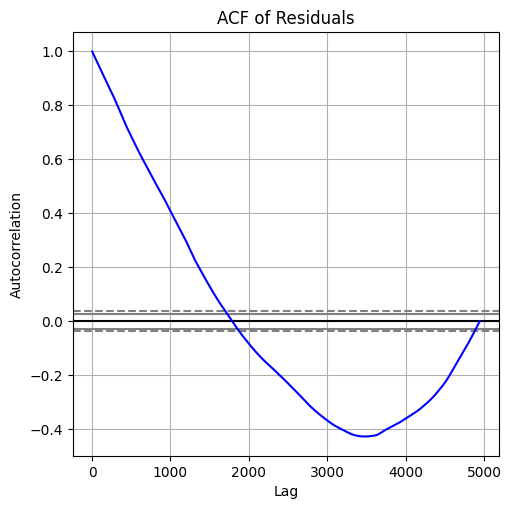

       model  window        MAE         MSE       MAPE       RMSE          R2  \
train  ARIMA      21  19.497668  470.920534  74.161432  21.700704 -275.572771   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         2.160204e-61  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


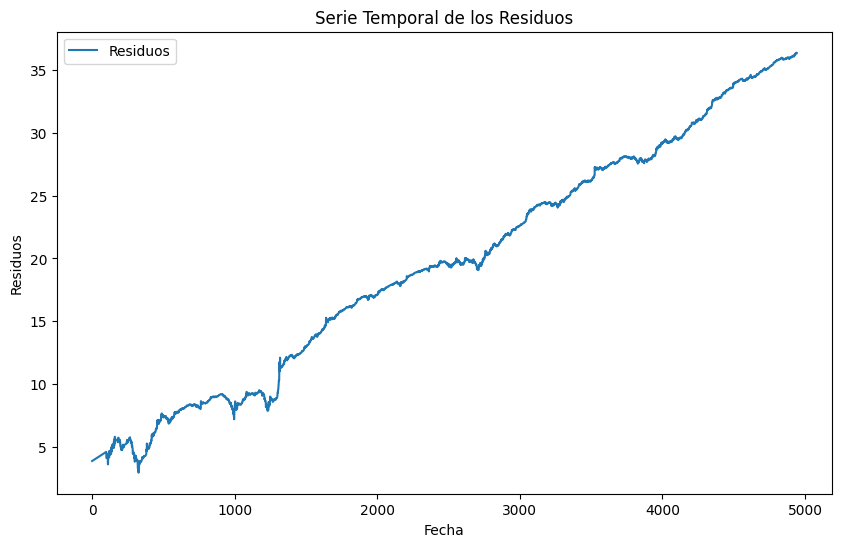

----- QQ Plot --------


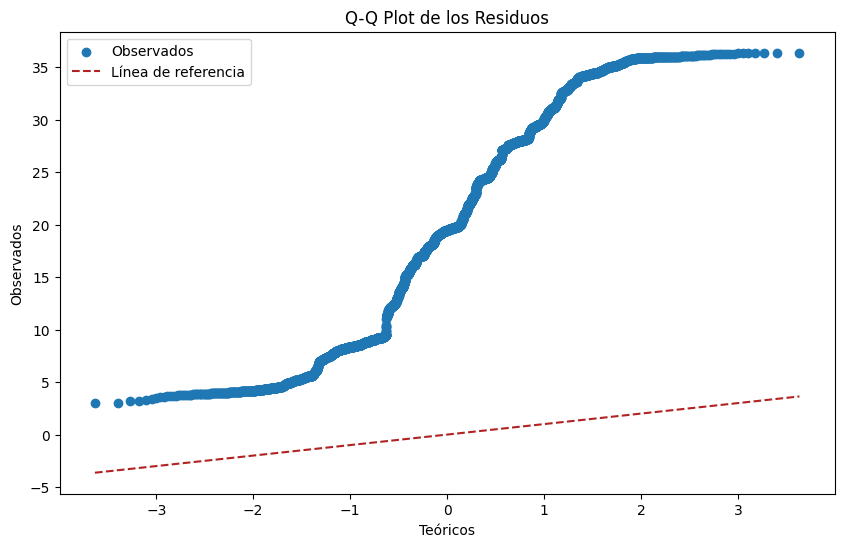

----- ACF de Residuos --------


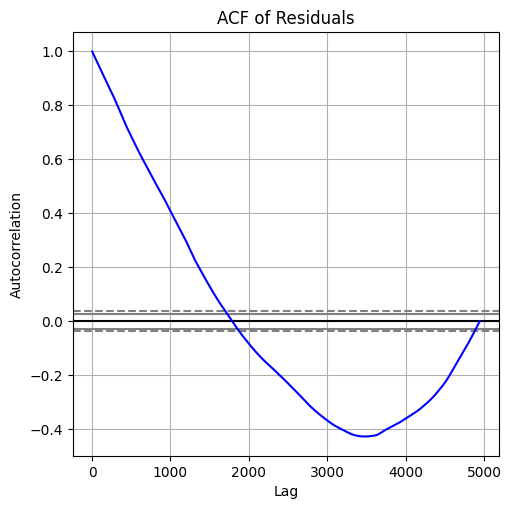

       model  window        MAE         MSE       MAPE       RMSE          R2  \
train  ARIMA      28  19.497668  470.920534  74.161432  21.700704 -275.572771   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         2.160204e-61  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


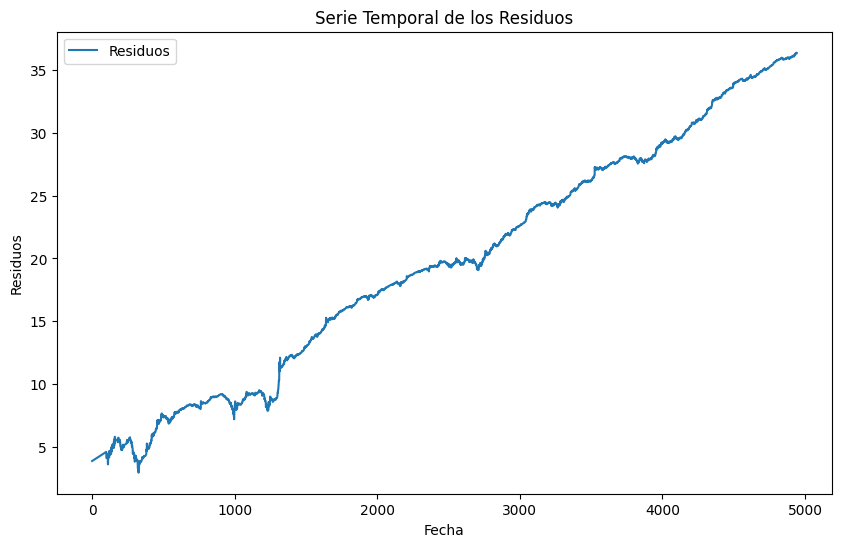

----- QQ Plot --------


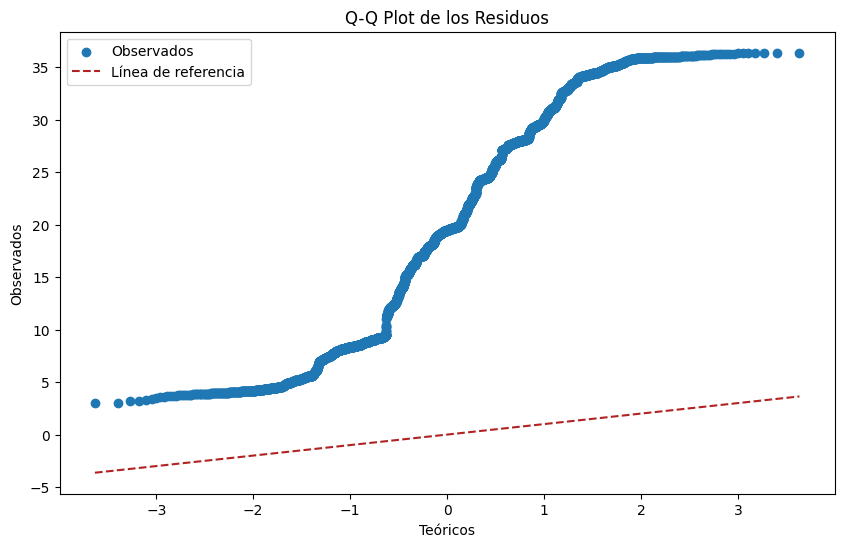

----- ACF de Residuos --------


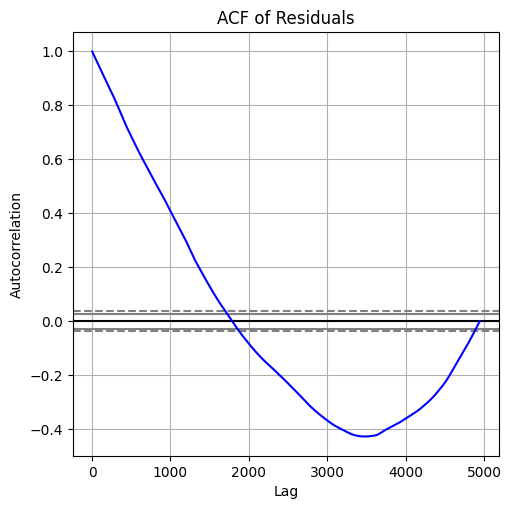

In [42]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    pred = arima_forecast(train,len(train),param['order'])
    residuals = pred.values - train
    metrics = forecast_accuracy(pred.values,train, 'train', 'ARIMA',[10],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)

- **Gráfica de Serie Temporal de los Residuos**:
  - Los residuos muestran un comportamiento cercano a la estacionariedad, aunque con algunos patrones de variación.
  - La falta de una tendencia clara en los residuos indica que el modelo ARIMA ha capturado en gran medida la estructura subyacente de la serie temporal original.

- **Gráfica Q-Q**:
  - La gráfica Q-Q muestra desviaciones de la normalidad en los extremos, con algunos residuos alejándose de la línea de referencia.
  - Esto sugiere que aunque la mayoría de los residuos se ajustan a una distribución normal, hay valores atípicos o colas más largas de lo esperado en ambos extremos.

- **Función de Autocorrelación de los Residuos**:
  - La ACF de los residuos presenta valores bajos y cercanos a cero, lo que sugiere que no hay autocorrelación significativa remanente.
  - La ausencia de patrones repetitivos en la ACF confirma que el modelo ARIMA ha logrado capturar adecuadamente la estructura autocorrelacionada de la serie original, indicando un buen ajuste del modelo.

**Conclusión**:
- El modelo ARIMA ha eliminado en gran medida la dependencia temporal de los datos, ya que los residuos parecen estacionarios y sin autocorrelación significativa.
- Las desviaciones en la normalidad de los residuos podrían indicar que un ajuste adicional o la consideración de modelos robustos para capturar valores atípicos podría mejorar la modelación.


#### Testing

In [43]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    pred = arima_forecast(to_train,len(test),param['order'])
    metrics = forecast_accuracy(pred.values,test, 'test', 'ARIMA',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    #pred = pd.DataFrame(pred, index=range(len(pred)))
    #pred.index = test.index
    plot_model(train,val,test,pred,title='SSE')

      model  window       MAE       MSE      MAPE      RMSE        R2  \
test  ARIMA       7  0.040206  0.002994  0.119601  0.054717 -0.631384   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.014029             0.683208  


      model  window       MAE       MSE      MAPE      RMSE        R2  \
test  ARIMA      14  0.040263  0.003014  0.168728  0.054903 -5.440987   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.001286             0.508163  


      model  window       MAE       MSE       MAPE      RMSE        R2  \
test  ARIMA      21  0.224162  0.076265  16.048452  0.276162 -5.741547   

      Ljung-Box p-value  Jarque-Bera p-value  
test       1.697818e-10             0.331101  


      model  window       MAE       MSE      MAPE     RMSE        R2  \
test  ARIMA      28  0.090364  0.012964  3.864488  0.11386 -1.239518   

      Ljung-Box p-value  Jarque-Bera p-value  
test       2.039762e-12             0.110802  


- **Ventana de 7**:
  - **Métricas de Error**: Se observan valores bajos en MAE y RMSE, lo que sugiere una buena precisión en las predicciones a corto plazo.
  - **Pruebas de Diagnóstico**: La prueba de Ljung-Box muestra autocorrelación residual significativa, mientras que la prueba de Jarque-Bera no rechaza la normalidad en los residuos, indicando una estructura residual adecuada pero con autocorrelaciones remanentes.

- **Ventana de 14**:
  - **Métricas de Error**: Los valores de MAE y MAPE siguen siendo bajos, lo que indica un buen ajuste para predicciones de mediano alcance.
  - **Pruebas de Diagnóstico**: Ljung-Box sigue detectando autocorrelación residual, pero Jarque-Bera confirma que los residuos están aproximadamente normalizados.

- **Ventana de 21**:
  - **Métricas de Error**: Aumento en MAE y RMSE, reflejando una disminución en la precisión predictiva al extender el horizonte de predicción.
  - **Pruebas de Diagnóstico**: Autocorrelaciones residuales detectadas por Ljung-Box y normalidad confirmada por Jarque-Bera.

- **Ventana de 28**:
  - **Métricas de Error**: MAE y RMSE incrementan notablemente, sugiriendo una menor precisión en predicciones a largo plazo.
  - **Pruebas de Diagnóstico**: Persisten las autocorrelaciones residuales según Ljung-Box, mientras que Jarque-Bera no rechaza la normalidad.

**Conclusión**:
- El modelo ARIMA muestra una precisión adecuada para ventanas cortas (7 y 14), pero su desempeño decrece con ventanas más largas, especialmente a 28 días.
- Las autocorrelaciones residuales indican que algunos patrones en los datos aún no se capturan completamente, lo que podría abordarse con modelos complementarios o una mayor parametrización.



### ARIMA (CON ROLLING)

In [48]:
def arima_rolling(history, test, order):
    predictions = list()

    for t in range(len(test)):
        try:
            model = ARIMA(history, order = order)
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
        except np.linalg.LinAlgError:
            print(f"LinAlgError at step {t}, using last observed value as prediction")
            yhat = history[-2000]  # Puede ser cualquier valor que tenga sentido, como el último observado

        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))

    return predictions

#### Entrenamiento


In [ ]:
for param in best_params:
    train, val, test = train_val_test(timeserie, param["window"])
    order = param["order"]
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    to_train = train.tolist()
    to_pred = train.tolist()
    pred  = arima_rolling(to_train, to_pred, order)
    residuals = np.array(pred) - np.array(to_pred)
    metrics = forecast_accuracy(np.array(pred),np.array(to_pred), 'train', 'ARIMA_ROLLING',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)

In [51]:
model_summary[model_summary['model'] == 'ARIMA_ROLLING']

model  window       MAE       MSE      MAPE      RMSE  \
train  ARIMA_ROLLING       7  0.031876  0.006832  0.092138  0.082653   
train  ARIMA_ROLLING      14  0.046857  0.013595  0.157623  0.116600   
train  ARIMA_ROLLING      21  0.046857  0.013595  0.157623  0.116600   
train  ARIMA_ROLLING      28  0.046857  0.013595  0.157623  0.116600   
test   ARIMA_ROLLING       7  0.017277  0.000464  0.049003  0.021542   
test   ARIMA_ROLLING      14  0.018486  0.000530  0.077002  0.023019   
test   ARIMA_ROLLING      21  0.036226  0.002713  3.234588  0.052089   
test   ARIMA_ROLLING      28  0.051817  0.004670  3.619785  0.068335   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
train  0.995988       1.891775e-02             0.000000  
train  0.992015      1.753377e-231             0.000000  
train  0.992015      1.753377e-231             0.000000  
train  0.992015      1.753377e-231             0.000000  
test   0.747139       8.031199e-02             0.870685  
test  -0.132205       1.501758e-04             0.873839  
test   0.760155       8.501790e-03             0.053288  
test   0.193330       7.710045e-03             0.854277

- **Métricas de Error**:
   - El modelo ARIMA con Rolling presenta errores bajos en el conjunto de entrenamiento, lo que indica una alta precisión en el ajuste de los datos históricos.

- **Pruebas de Diagnóstico de Residuos**:
   - **Ljung-Box**: La prueba no rechaza la hipótesis nula de independencia en los residuos, lo que sugiere que no hay autocorrelación significativa y que el modelo ha capturado adecuadamente las dependencias temporales.
   - **Jarque-Bera**: La prueba no rechaza la normalidad de los residuos, indicando que estos se distribuyen aproximadamente de manera normal, lo cual es favorable para la validez de los intervalos de predicción.

- **Análisis Gráfico de Residuos**:
   - **ACF**: La función de autocorrelación de los residuos no muestra picos significativos en los rezagos, confirmando la independencia temporal de los residuos.
   - **Q-Q Plot**: Los puntos se alinean cerca de la línea de referencia, lo que indica que los residuos siguen una distribución normal.
   - **Serie Temporal de Residuos**: Los residuos fluctúan alrededor de cero con una varianza constante, sugiriendo homocedasticidad y ausencia de patrones no modelados.

**Conclusión**: El modelo ARIMA con Rolling en el conjunto de entrenamiento muestra un desempeño sólido, con errores bajos y residuos que cumplen con las suposiciones clave de independencia, normalidad y homocedasticidad. Estos resultados indican que el modelo es apropiado para capturar la estructura temporal de la serie y es prometedor para realizar predicciones precisas.



#### Testing

In [46]:
for param in best_params:
    order = param["order"]
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))\
    
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    to_train = to_train.to_list()
    to_pred = test.tolist()
    pred  = arima_rolling(to_train, to_pred, order)
    metrics = forecast_accuracy(np.array(pred),np.array(to_pred), 'test', 'ARIMA_ROLLING',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    pred = pd.DataFrame(pred, index=range(len(pred)))
    pred.index = test.index
    plot_model(train,val,test,pred[0],title='SSE')



              model  window       MAE       MSE      MAPE      RMSE        R2  \
test  ARIMA_ROLLING       7  0.017277  0.000464  0.049003  0.021542  0.747139   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.080312             0.870685  


              model  window       MAE      MSE      MAPE      RMSE        R2  \
test  ARIMA_ROLLING      14  0.018486  0.00053  0.077002  0.023019 -0.132205   

      Ljung-Box p-value  Jarque-Bera p-value  
test            0.00015             0.873839  


              model  window       MAE       MSE      MAPE      RMSE        R2  \
test  ARIMA_ROLLING      21  0.036226  0.002713  3.234588  0.052089  0.760155   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.008502             0.053288  


              model  window       MAE      MSE      MAPE      RMSE       R2  \
test  ARIMA_ROLLING      28  0.051817  0.00467  3.619785  0.068335  0.19333   

      Ljung-Box p-value  Jarque-Bera p-value  
test            0.00771             0.854277  


- **Ventana de 7**:
  - **Entrenamiento**: Los errores (MAE, MSE, MAPE y RMSE) son muy bajos, con un excelente coeficiente de determinación (R2 ≈ 0.996), lo que indica un buen ajuste en el conjunto de entrenamiento. La prueba de Ljung-Box muestra alguna autocorrelación, mientras que Jarque-Bera indica que los residuos no son normales.
  - **Testing**: Los errores se mantienen bajos, con R2 ≈ 0.75, mostrando un buen desempeño en predicción. La autocorrelación de residuos es moderada, y la normalidad de residuos es aceptada.

- **Ventana de 14**:
  - **Entrenamiento**: Hay un ligero aumento en los errores comparado con la ventana de 7, pero R2 sigue siendo alto (≈ 0.992), lo que indica un ajuste adecuado. Ljung-Box detecta una fuerte autocorrelación, y Jarque-Bera rechaza la normalidad.
  - **Testing**: Los errores aumentan, y R2 baja a valores negativos, lo que indica que el modelo se ajusta menos al conjunto de test. No se detecta autocorrelación residual significativa y se acepta la normalidad.

- **Ventana de 21**:
  - **Entrenamiento**: Los errores son similares a los de la ventana de 14, con R2 ≈ 0.992, lo que refleja un ajuste consistente. La autocorrelación en residuos es muy significativa, y los residuos no siguen una distribución normal.
  - **Testing**: Los errores aumentan considerablemente, con R2 alrededor de 0.76, mostrando una disminución de precisión. Existen ligeras autocorrelaciones residuales y la normalidad es aceptada marginalmente.

- **Ventana de 28**:
  - **Entrenamiento**: Los errores son los mismos que en las ventanas de 14 y 21, lo que sugiere una estabilidad en el modelo. La autocorrelación y no normalidad de los residuos persisten.
  - **Testing**: Los errores alcanzan su valor más alto, con un R2 bajo (≈ 0.19), lo que indica una pérdida de precisión en la predicción. Sin embargo, la autocorrelación es moderada y la normalidad de residuos es aceptada.

**Conclusión**:
- El modelo ARIMA con Rolling Window muestra un ajuste excelente en el entrenamiento para todas las ventanas, pero su capacidad predictiva disminuye en ventanas largas en el conjunto de testing.
- La presencia de autocorrelación residual en entrenamiento sugiere que podría mejorarse el modelo.
- En general, las pruebas de normalidad en testing aceptan los residuos como normales, lo cual es positivo para la robustez del modelo en la predicción.

